<a href="https://colab.research.google.com/github/dho619/TCC_Pos_IA/blob/main/Algoritmo_RedesNeurais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback


In [2]:
#Para documentação de passo a passo e justificativa dessa função, pode encontrá-la no arquivo TratamentoDosDados.ipynb
def TratarDadosBaseWalmart(df):
  df.Date=pd.to_datetime(df.Date, format='%d-%m-%Y')
  df['Day'] = df.Date.dt.day
  df['Month'] = df.Date.dt.month
  df['Year'] = df.Date.dt.year
  df.drop(['Date'], axis=1, inplace=True)

  df.drop_duplicates(inplace=True)

  ignoreFeatures = ['Weekly_Sales', 'Day']
  maximumToBeCategorical = 45
  features = [i for i in df.columns if i not in ignoreFeatures]
  uniqueValuesForFeature = df[features].nunique().sort_values()
  categoricalFeature = [];
  valuesFeature = [];
  for i in range(df[features].shape[1]):
      if uniqueValuesForFeature.values[i]<=maximumToBeCategorical:
          categoricalFeature.append(uniqueValuesForFeature.index[i])
      else:
          valuesFeature.append(uniqueValuesForFeature.index[i])
  for i in categoricalFeature:
    if df[i].nunique()==2:
        df[i]=pd.get_dummies(df[i], drop_first=True, prefix=str(i))
    if (df[i].nunique()>2):
        df = pd.concat([df.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df[i], prefix=str(i)))],axis=1)
    
  return df


In [44]:
#Para documentação de passo a passo e justificativa dessa função, pode encontrá-la no arquivo PreparaçãoDeDados.ipynb

def NormalizarValores(df, columns):
  for column in columns:
    df[column] = df[column]/df[column].max()

def PertenceAMesmaLoja(df, num1, num2):
  if num1 < 0 or num2 < 0: return False
  for i in range(1, 46):
    if df["Store_" + str(i)][num1] != df["Store_" + str(i)][num2]: return False
  return True

def PreparaDados(df, formatoDados):
  target = "Weekly_Sales"

  df["SalesOneWeekAgo"] = np.zeros(len(df[target]))
  df["SalesTwoWeeksAgo"] = np.zeros(len(df[target]))
  df["SalesThreeWeeksAgo"] = np.zeros(len(df[target]))

  for i, sales in enumerate(df[target]):
    df["SalesOneWeekAgo"][i] = df[target][i-1] if PertenceAMesmaLoja(df, i, i-1) else df[target][i]
    df["SalesTwoWeeksAgo"][i] = df[target][i-2] if PertenceAMesmaLoja(df, i, i-2) else df[target][i]
    df["SalesThreeWeeksAgo"][i] = df[target][i-3] if PertenceAMesmaLoja(df, i, i-3) else df[target][i]

  #Normalizando valores
  columns = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]
  NormalizarValores(df, columns)

  filtro_treino = df["Year_2012"] == 0
  filtro_teste = df["Year_2012"] == 1

  train = df.where(filtro_treino).dropna()
  test =  df.where(filtro_teste).dropna()

  y_train = train[target].array
  X_train = train.drop([target, "Year_2010", "Year_2011", "Year_2012"],axis=1)
  
  y_test = test[target].array
  X_test = test.drop([target, "Year_2010", "Year_2011", "Year_2012"],axis=1)

  X_train.reset_index(drop=True,inplace=True)

  return X_train.astype(formatoDados), X_test.astype(formatoDados), y_train.astype(formatoDados), y_test.astype(formatoDados)

In [45]:
df = pd.read_csv('./Walmart.csv')
df = TratarDadosBaseWalmart(df)

X_train, X_test, y_train, y_test = PreparaDados(df, np.float32)
print('Base original  ---> ',df.shape,df.shape,'\nBase de Treino  ---> ',X_train.shape,y_train.shape,'\nBase de teste   ---> ', X_test.shape,'', y_test.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Base original  --->  (6435, 70) (6435, 70) 
Base de Treino  --->  (4500, 66) (4500,) 
Base de teste   --->  (1935, 66)  (1935,)


In [46]:
X_train_list = X_train.values;
X_test_list = X_test.values;
y_train_list = y_train.copy();

corte = int(len(X_train_list)*0.9)
X_validation = X_train_list[corte:]
X_train_list = X_train_list[:corte]
y_validation = y_train_list[corte:]
y_train_list = y_train_list[:corte]

In [6]:
def get_model():
    number_features = 66
    model = Sequential([
        Dense(36, input_shape = (number_features,), activation = 'relu'),
        Dense(36, activation = 'relu'),
        Dense(360, activation = 'relu'),
        Dense(360, activation = 'relu'),
        Dense(180, activation = 'relu'),
        Dense(180, activation = 'relu'),
        Dense(180, activation = 'relu'),
        Dense(90, activation = 'relu'),
        Dense(90, activation = 'relu'),
        Dense(30, activation = 'relu'),
        Dense(10, activation = 'relu'),
        Dense(1)
    ])
    
    model.compile(
         loss = 'mse',
         optimizer = 'adam'    
    )
    return model


In [7]:
def get_model2():
    number_features = 66
    model = Sequential([
        Dense(64, input_shape = (number_features,), activation = 'relu'),
        Dense(64, activation = 'relu'),
        Dense(320, activation = 'relu'),
        Dense(320, activation = 'relu'),
        Dense(160, activation = 'relu'),
        Dense(160, activation = 'relu'),
        Dense(160, activation = 'relu'),
        Dense(80, activation = 'relu'),
        Dense(80, activation = 'relu'),
        Dense(20, activation = 'relu'),
        Dense(10, activation = 'relu'),
        Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(
         loss = 'mse',
         optimizer = optimizer,    
         metrics=['mae', 'mse'])
    return model


In [57]:
# Define model
model = Sequential()
model.add(Dense(500, input_shape = (X_test.shape[1],), activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(1))
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])

In [58]:
history = model.fit(
        X_train_list,y_train_list,
        validation_data =(X_validation, y_validation),
        epochs = 100
)

Epoch 1/100


ValueError: ignored

In [53]:
predictions = model.predict(X_test_list)

r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), np.sqrt(mean_squared_error(y_test, predictions))

(0.9617593706662163, 67733.484, 104916.59)

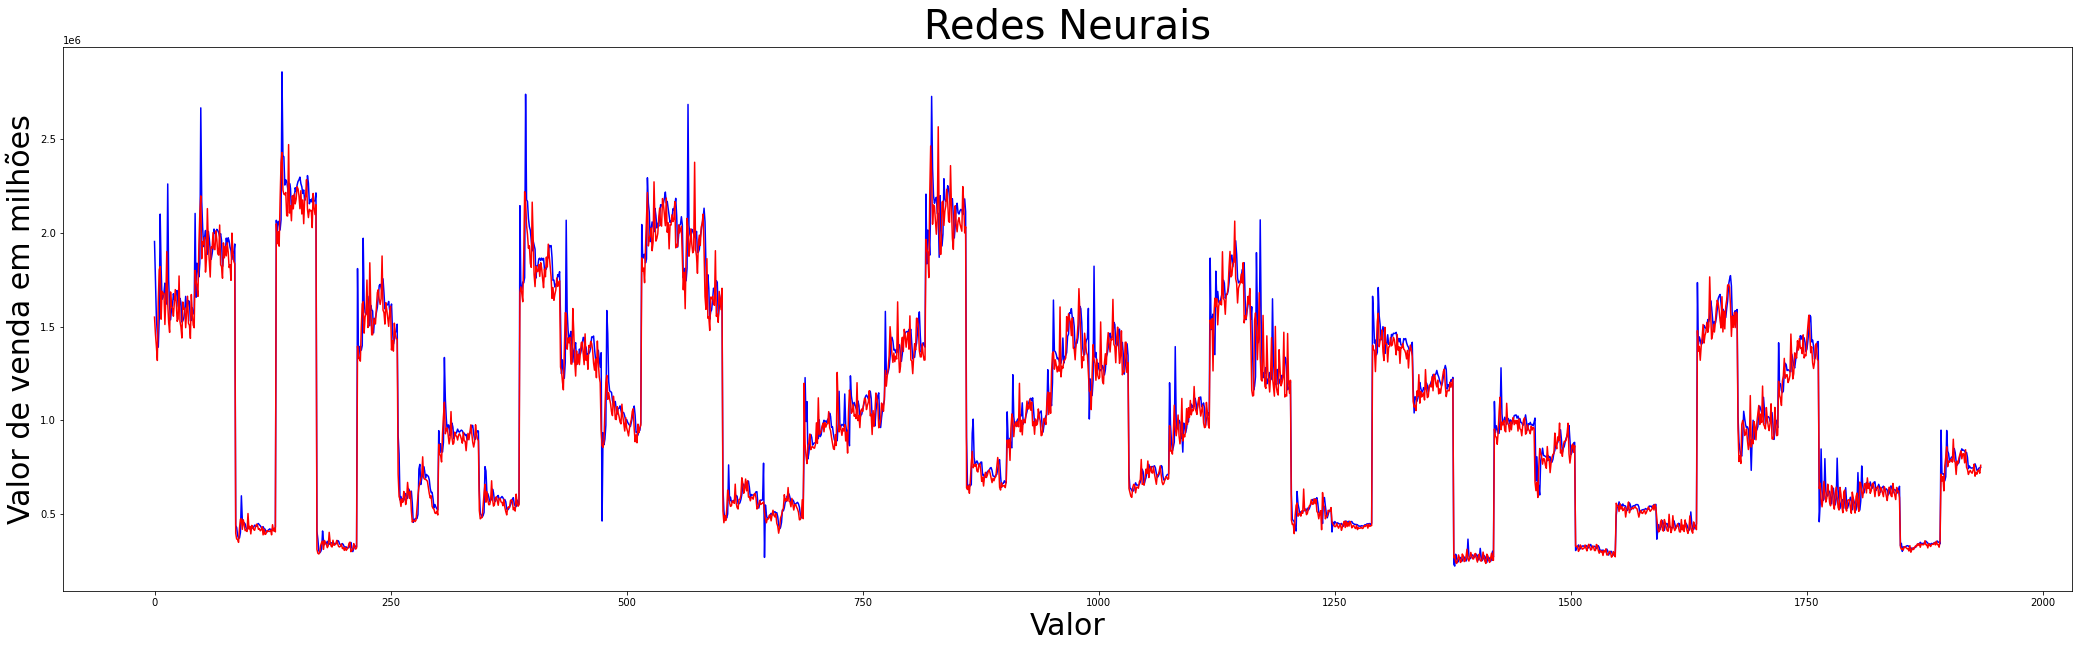

In [55]:
plt.figure(figsize = (36, 10)) 
plt.plot(range(len(predictions)), predictions, 'b')
plt.plot(range(len(predictions)), y_test, 'r')
plt.title("Redes Neurais", fontsize=40)
plt.xlabel("Valor", fontsize=30)
plt.ylabel("Valor de venda em milhões", fontsize=30)

plt.show()

Resultados Loja 1:
-1.5708023523870045 136392.47 182361.33


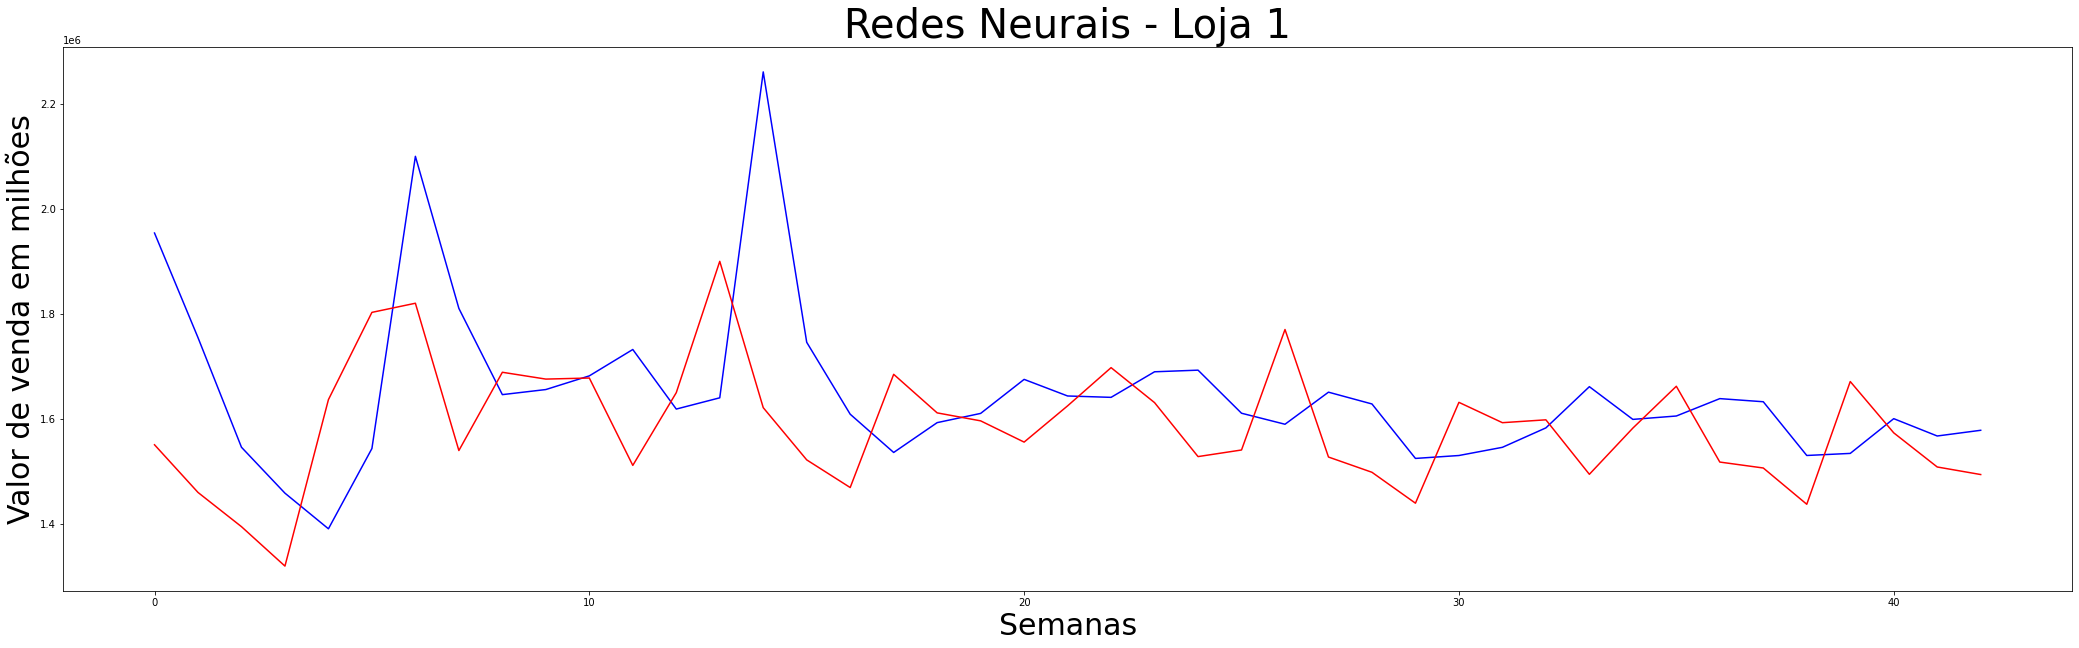

**************************************************
Resultados Loja 2:
-0.8877710514631512 114596.78 147478.84


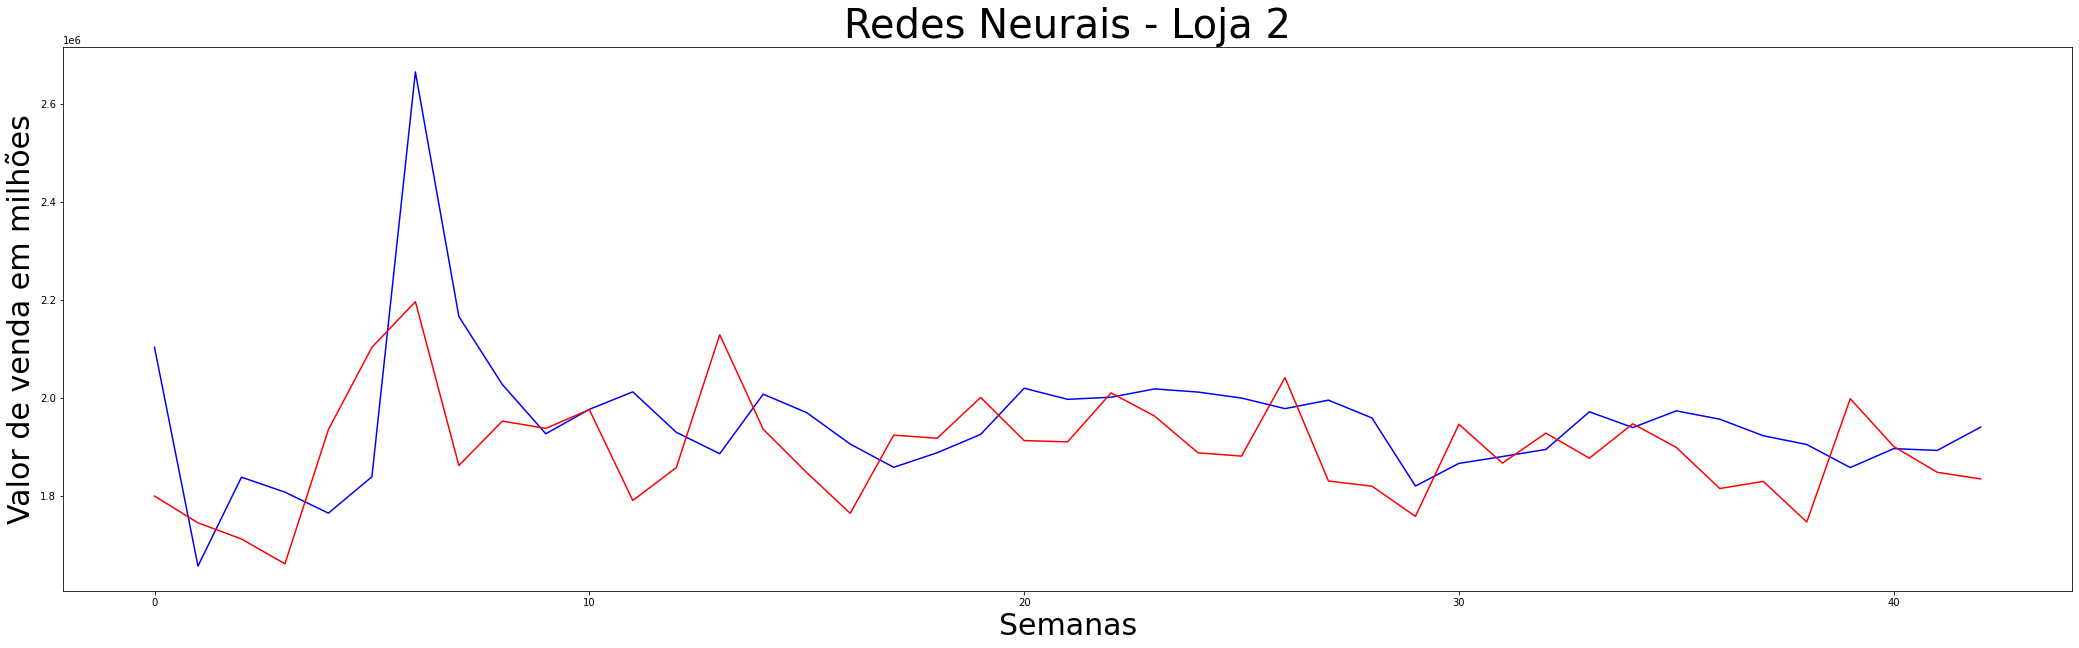

**************************************************
Resultados Loja 3:
-0.4461674147012795 24774.85 34330.348


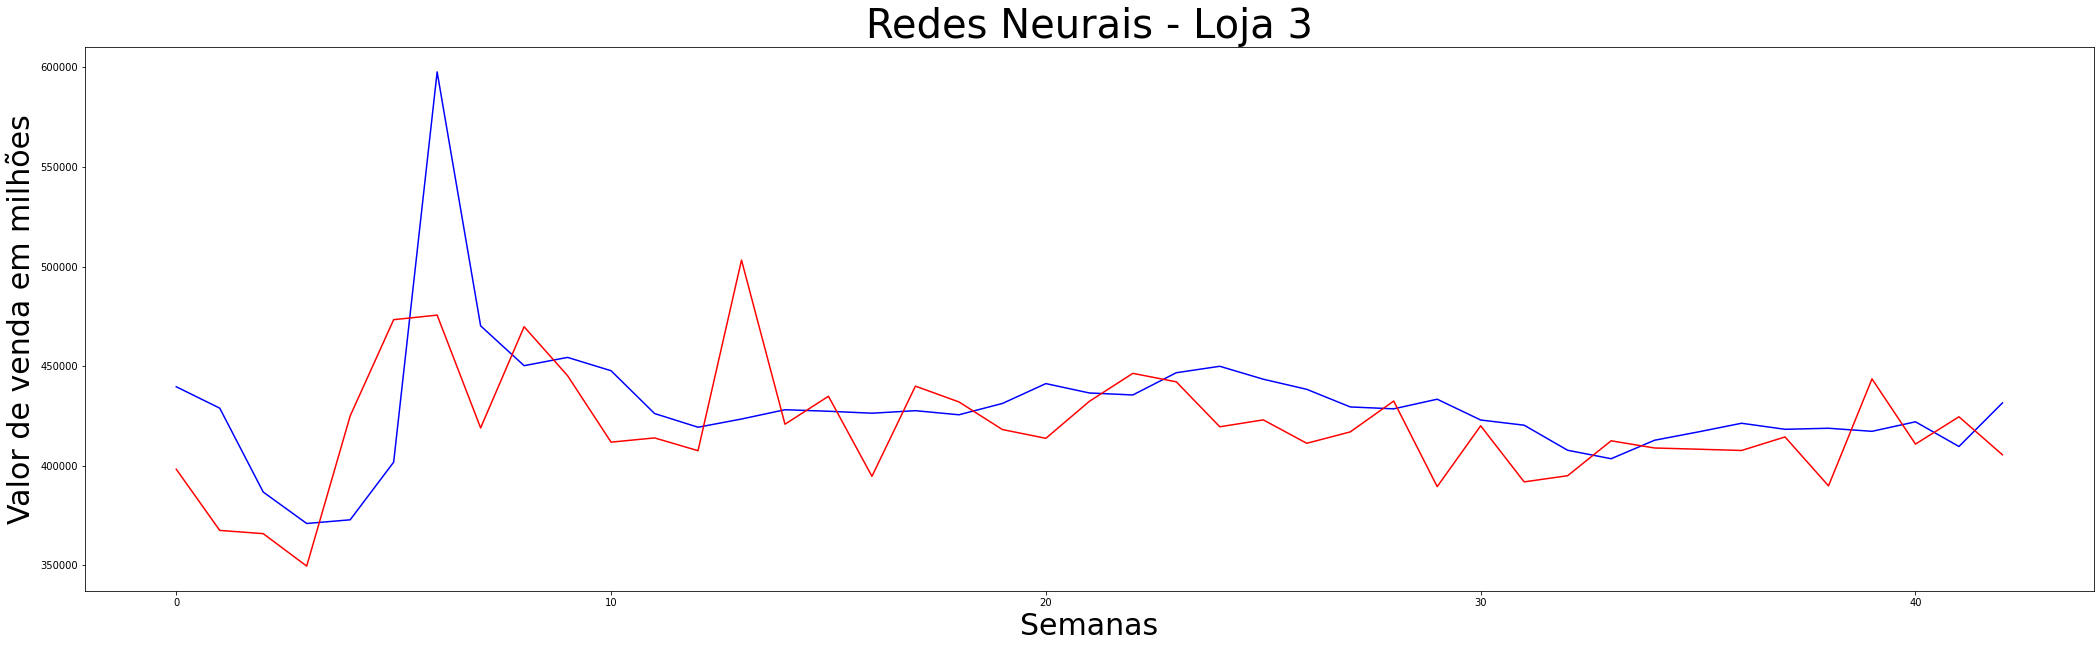

**************************************************
Resultados Loja 4:
-0.6979413251244002 104805.74 137547.7


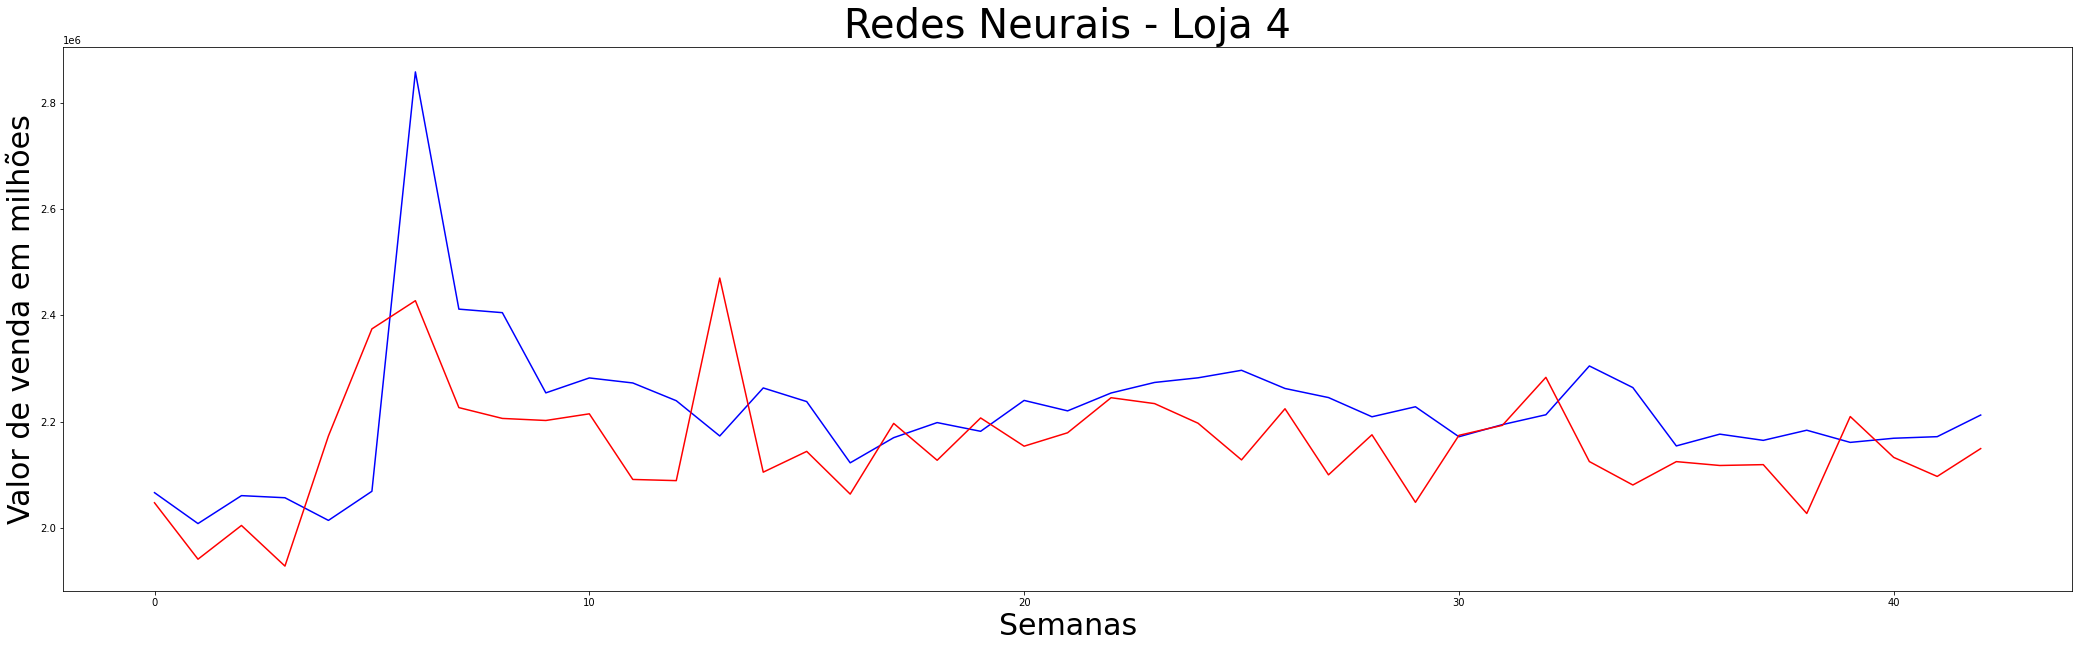

**************************************************
Resultados Loja 5:
-0.843747828334426 21015.87 29579.37


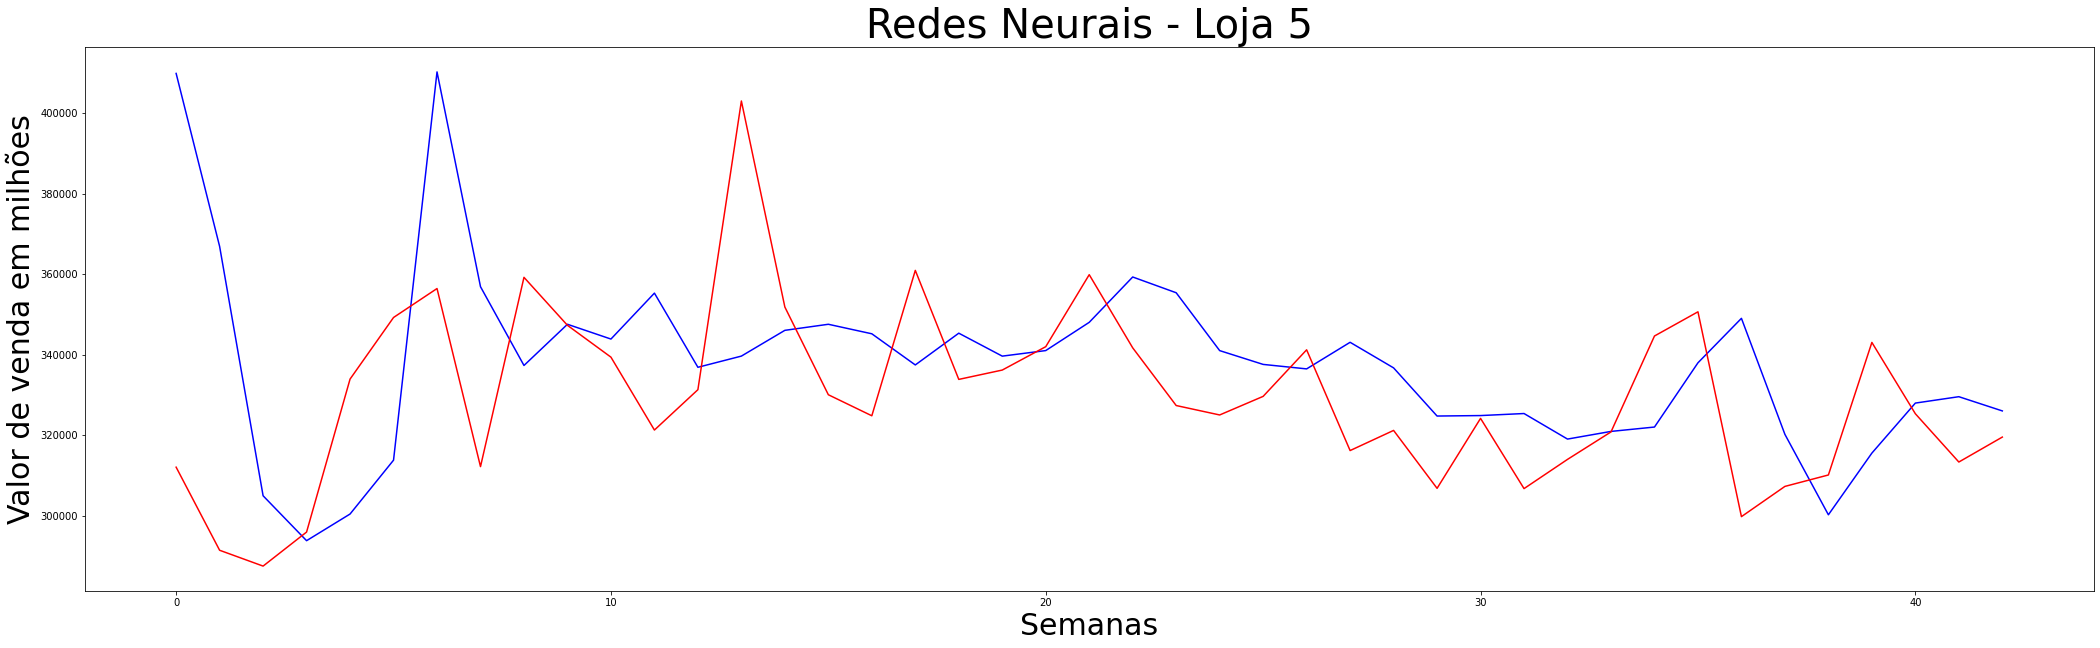

**************************************************
Resultados Loja 6:
-0.2756936884900032 101818.48 138517.28


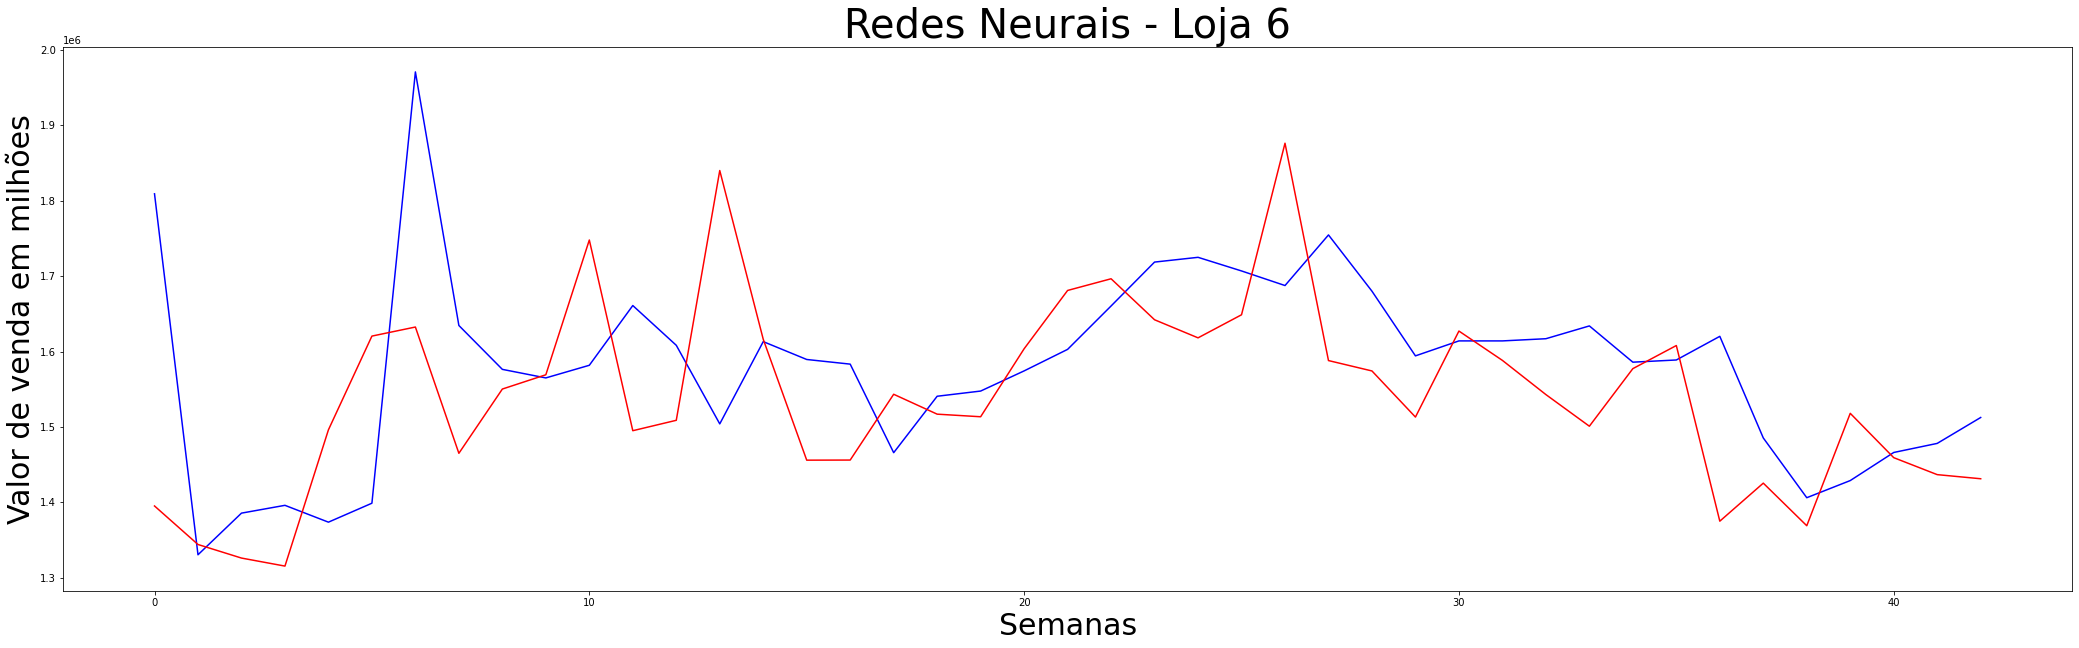

**************************************************
Resultados Loja 7:
0.2594708149192795 50001.395 69754.664


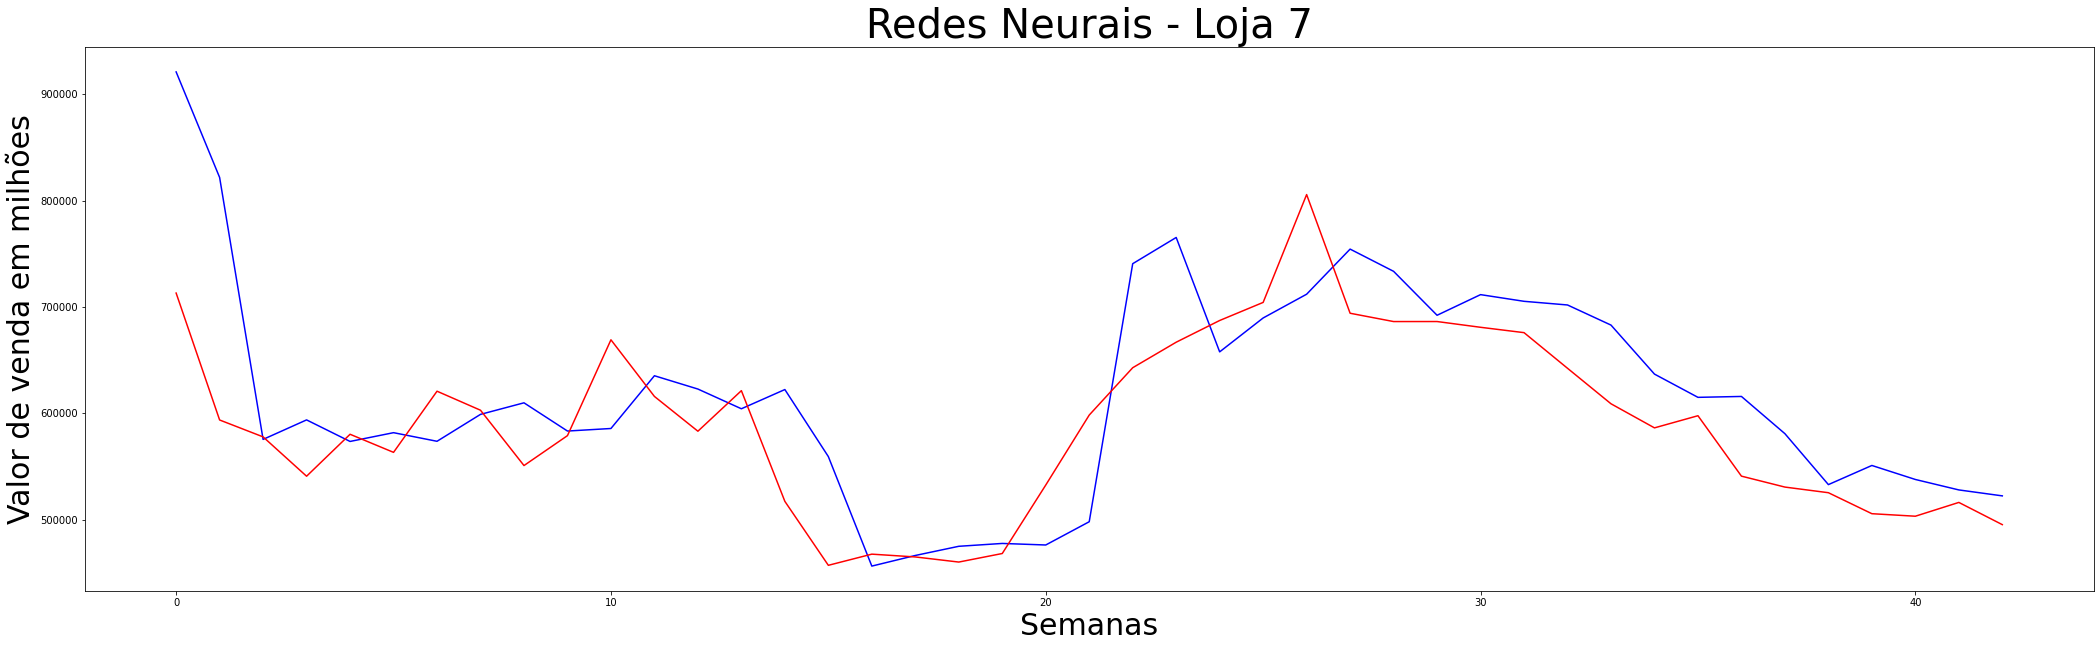

**************************************************
Resultados Loja 8:
-0.685241387473638 54496.06 72951.52


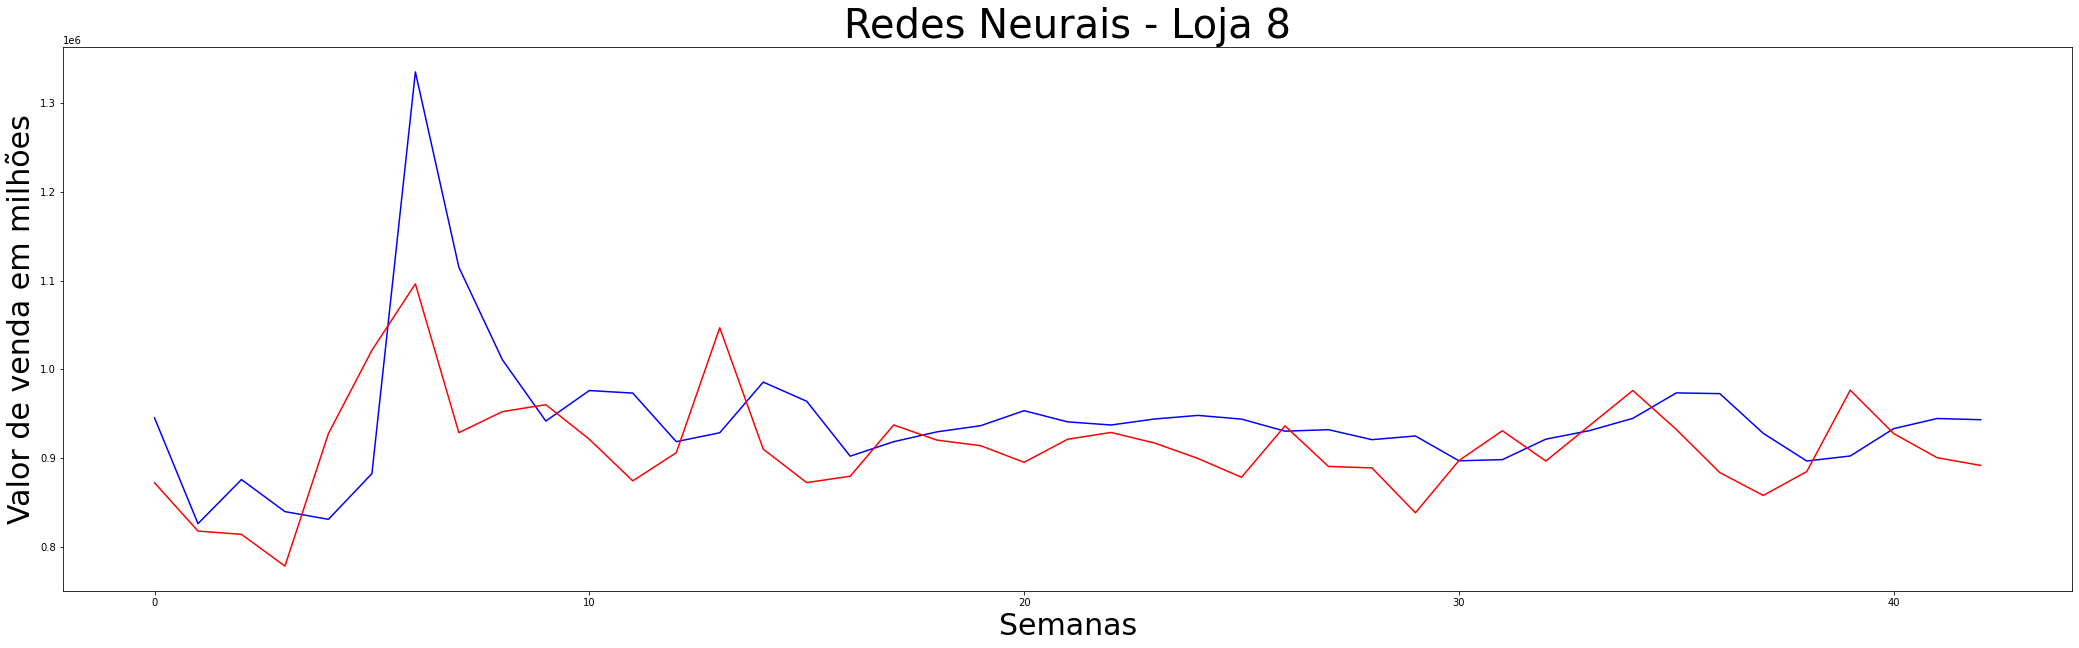

**************************************************
Resultados Loja 9:
-0.5008341441962969 35760.664 49938.277


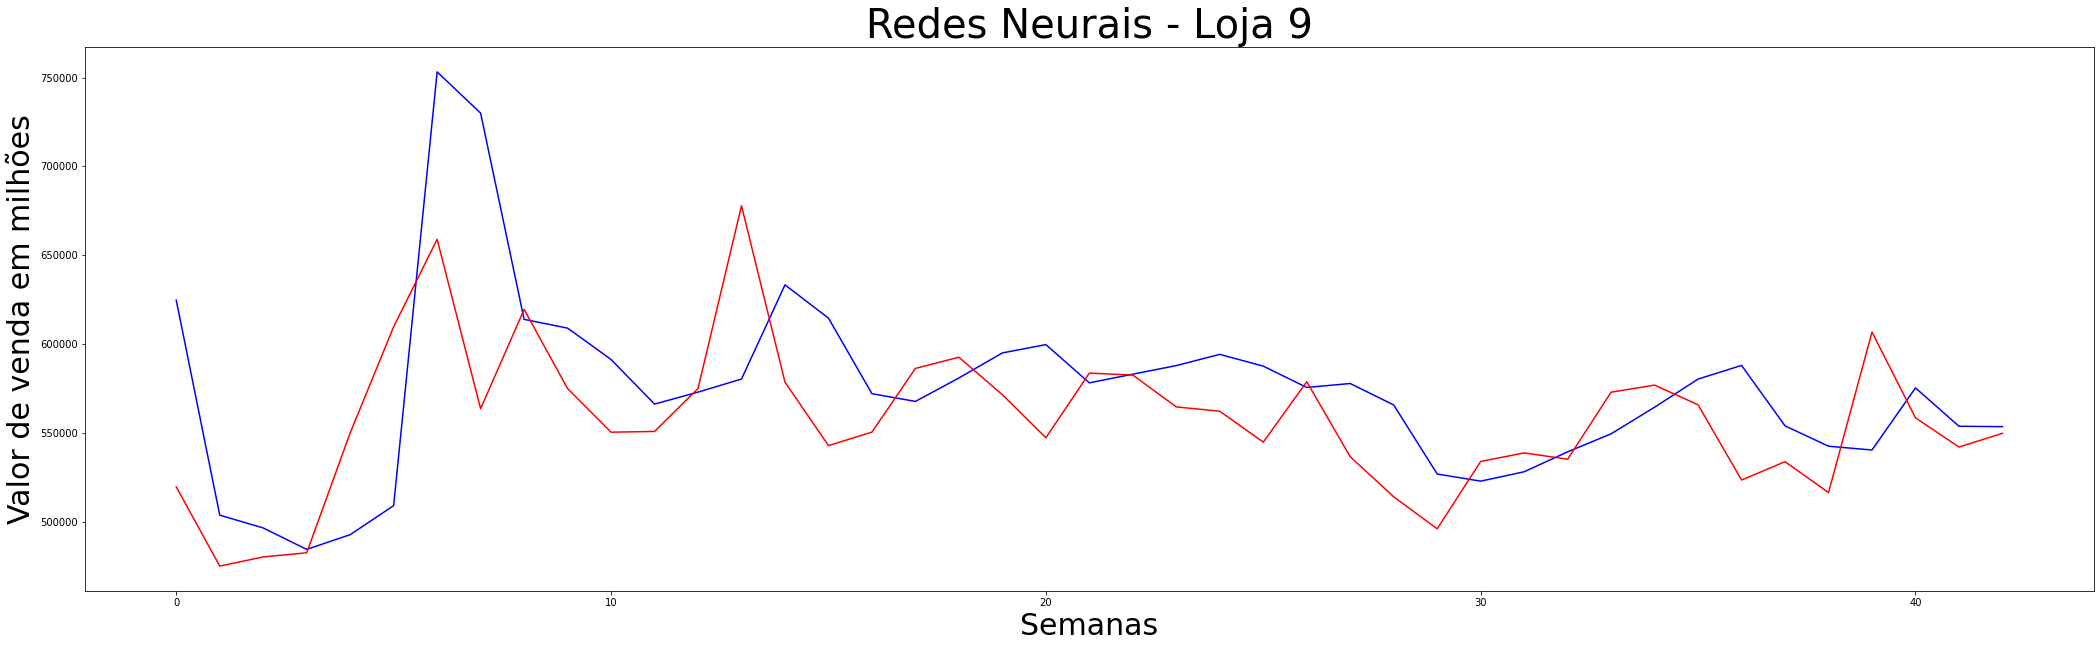

**************************************************
Resultados Loja 10:
-0.5096687384425629 117063.51 168742.38


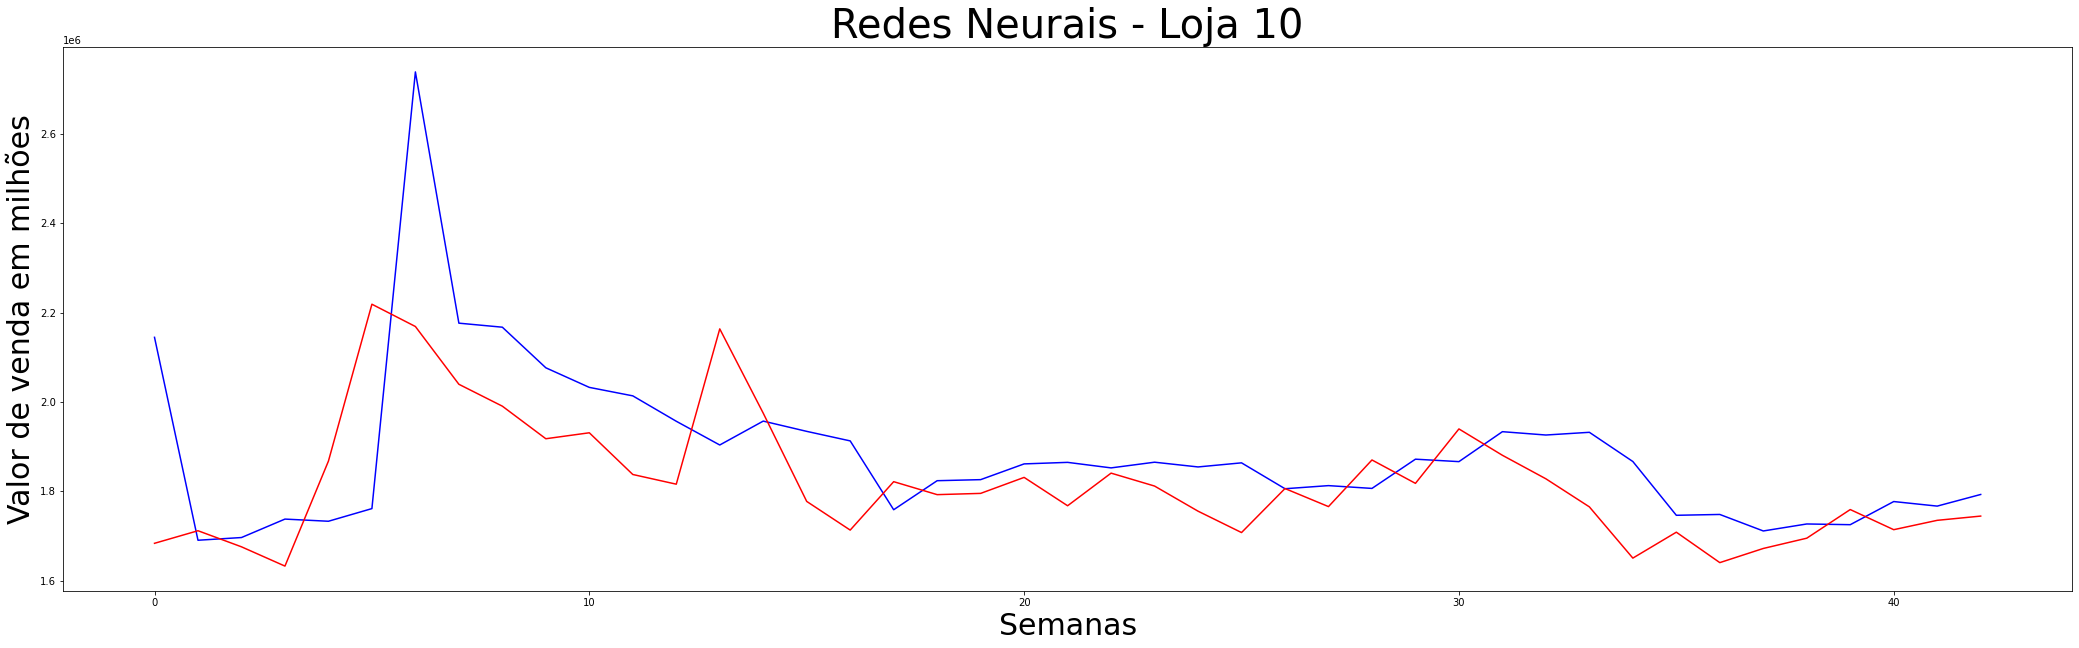

**************************************************
Resultados Loja 11:
-1.0139592514122642 99863.81 136708.6


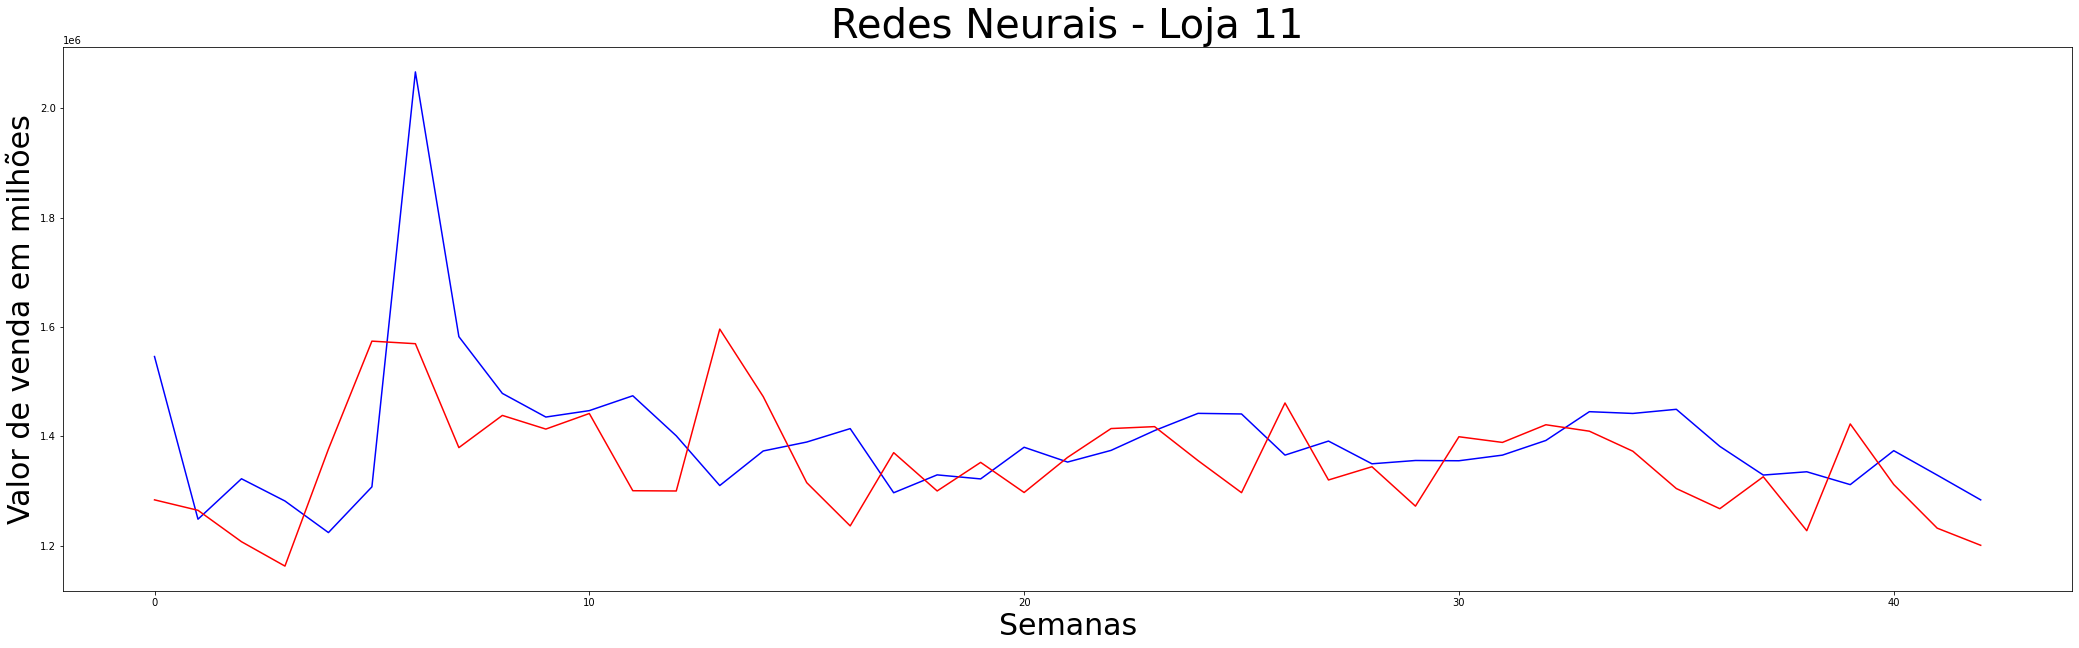

**************************************************
Resultados Loja 12:
-1.4752936929196796 86552.59 134785.73


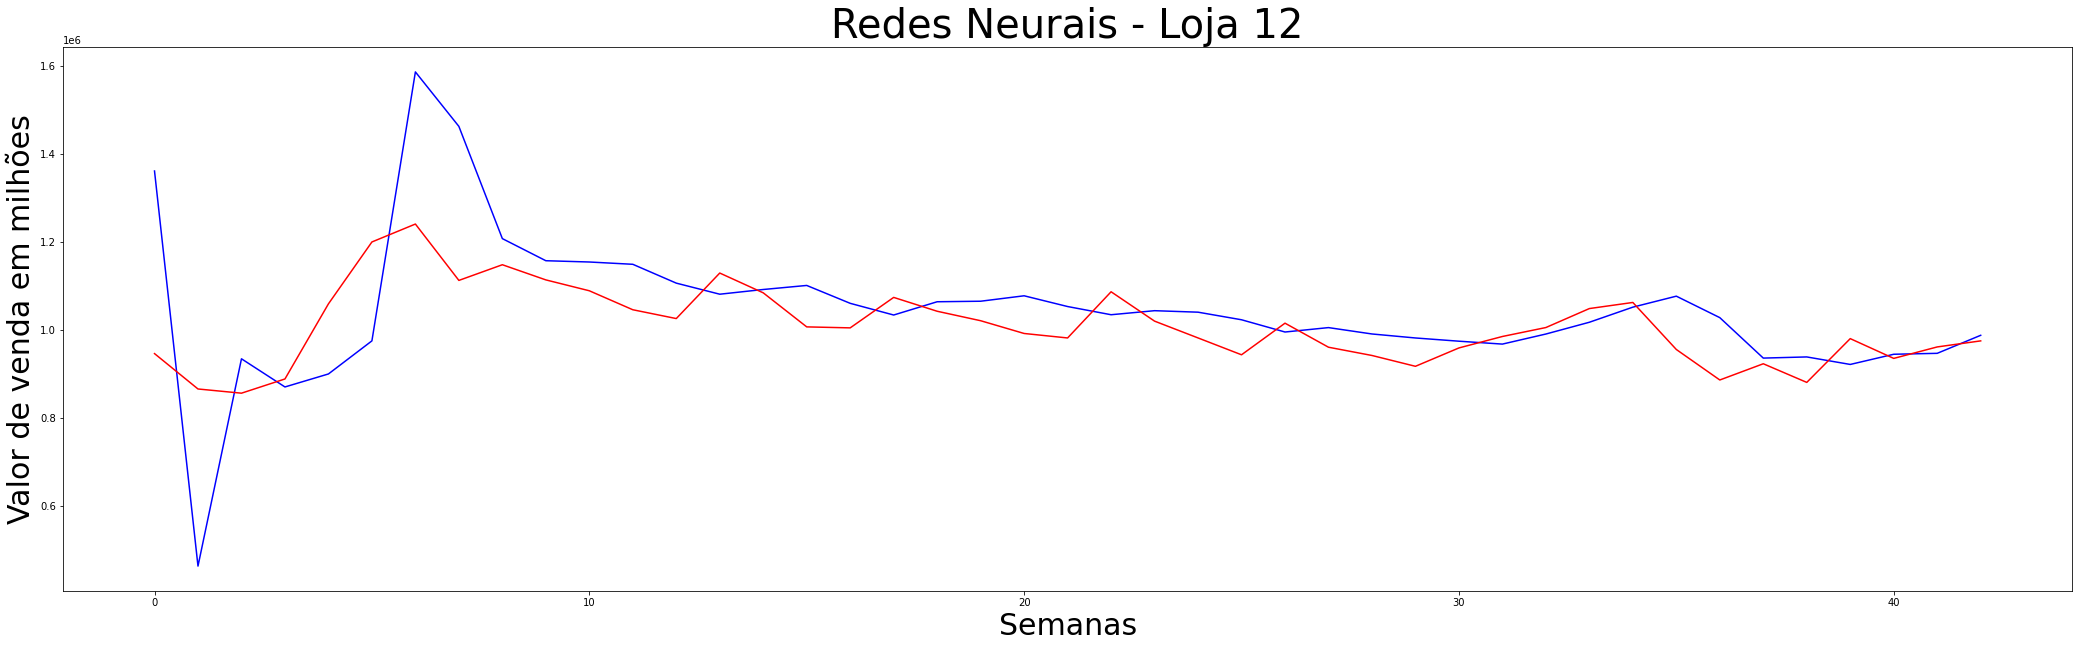

**************************************************
Resultados Loja 13:
-0.10792794435181197 91399.85 115230.586


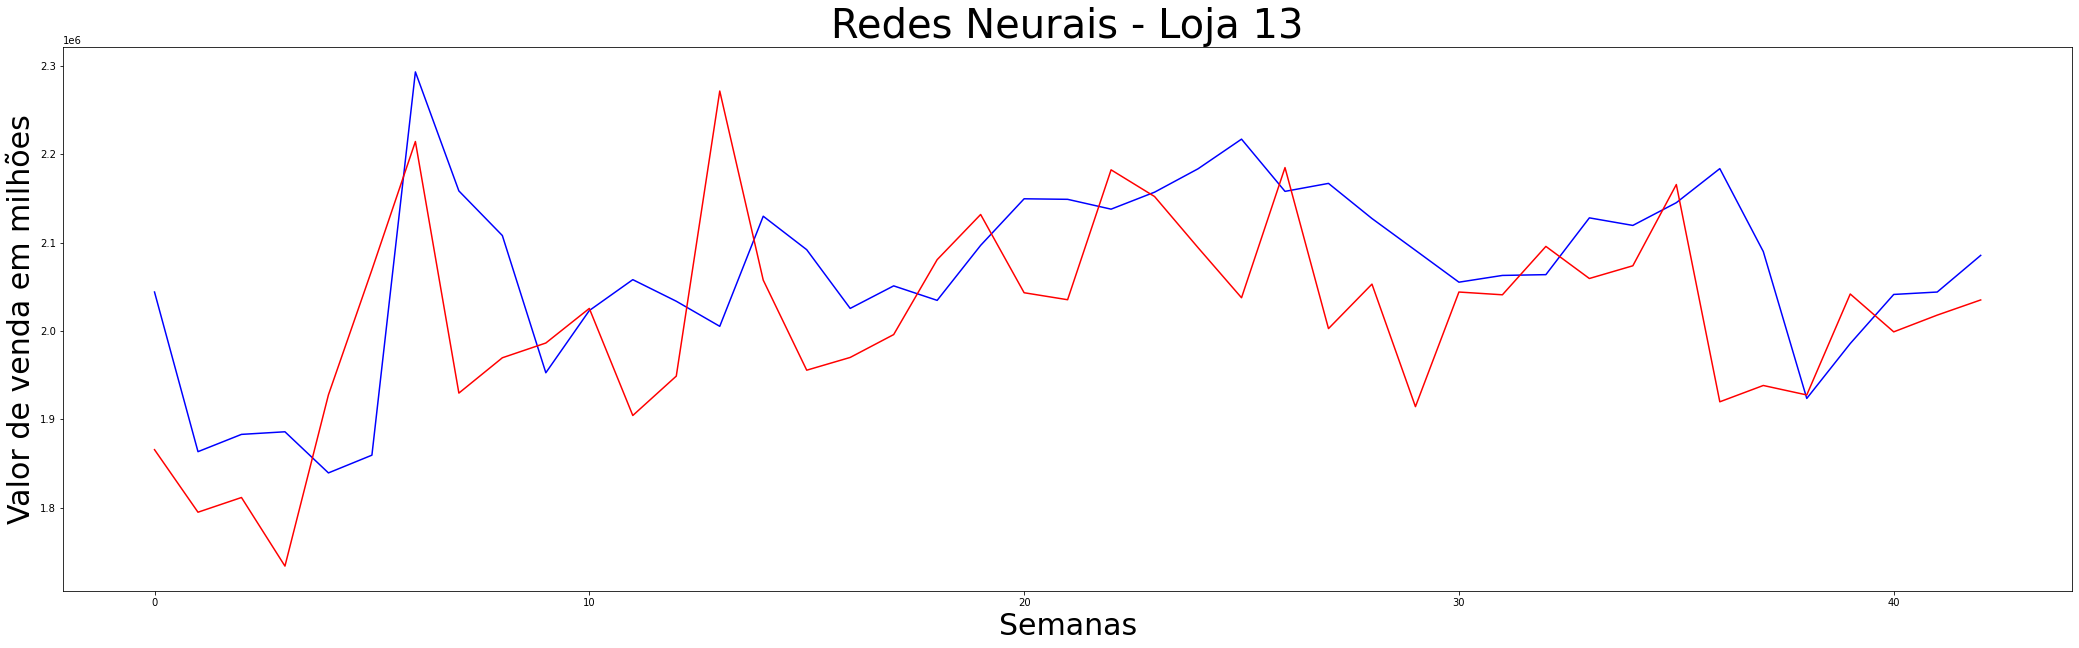

**************************************************
Resultados Loja 14:
0.14789376799018372 130991.05 181336.2


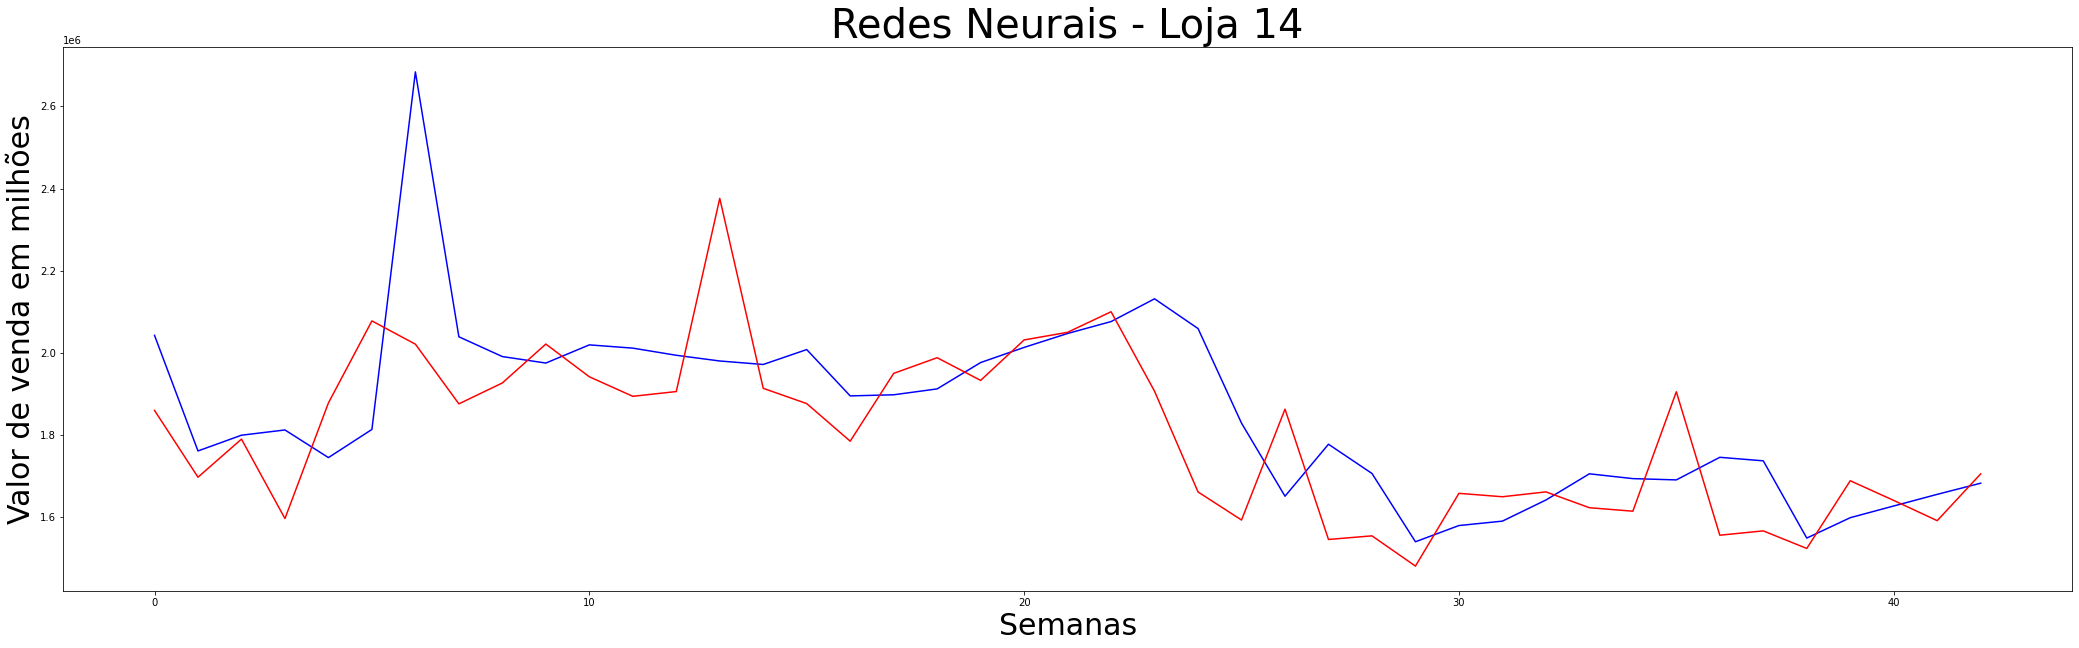

**************************************************
Resultados Loja 15:
0.0011423126011530504 38106.766 52569.65


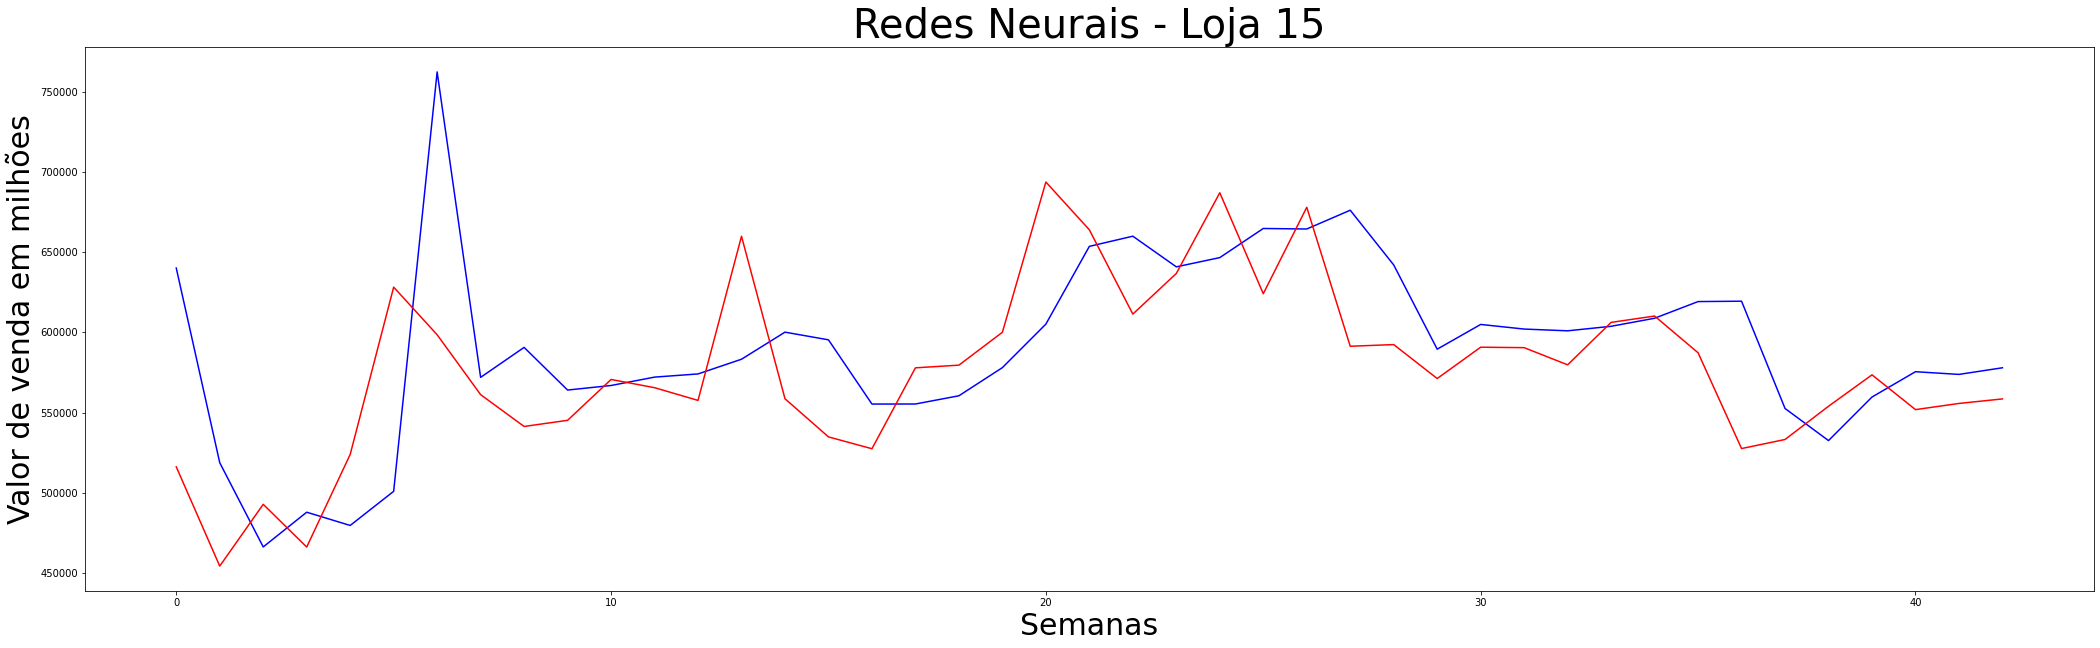

**************************************************
Resultados Loja 16:
-0.42737775388029586 38642.58 60448.703


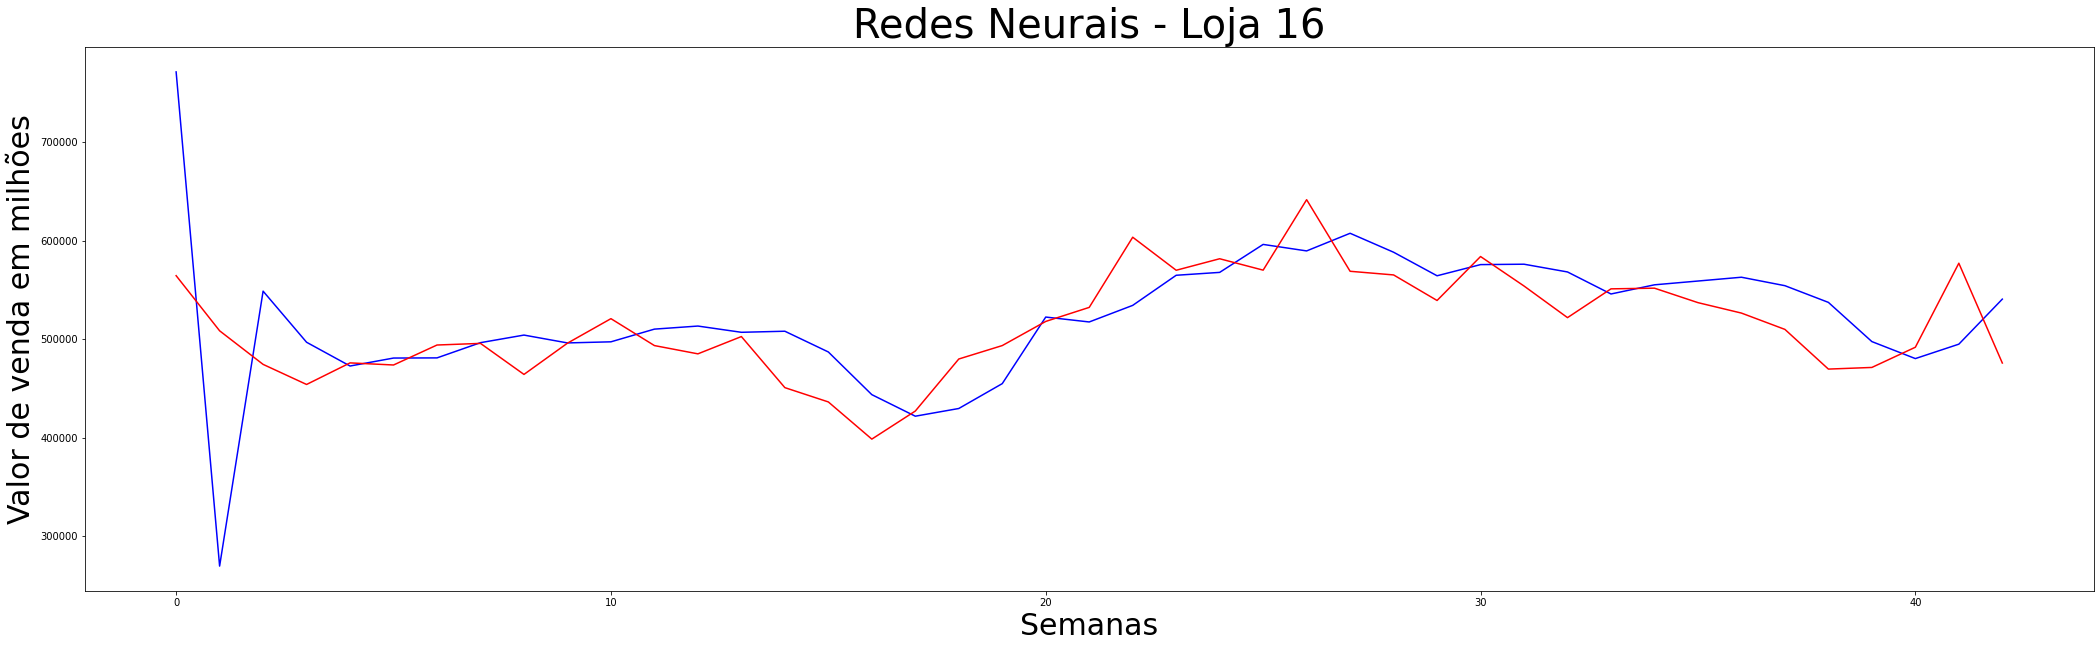

**************************************************
Resultados Loja 17:
-0.8556488489420848 82144.83 127269.234


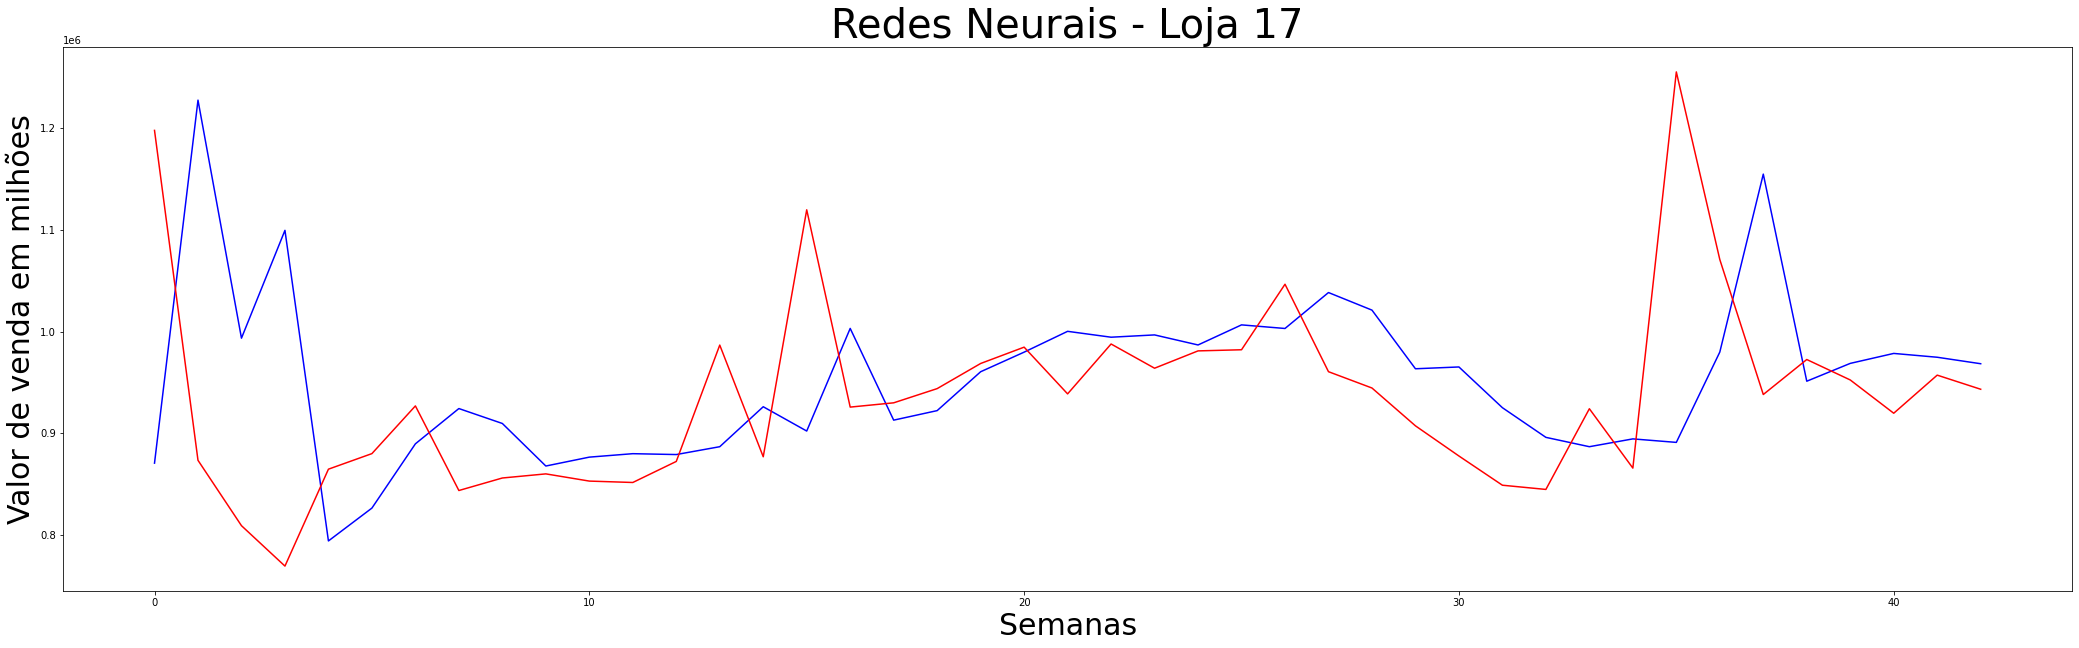

**************************************************
Resultados Loja 18:
-0.488502378559345 69628.47 90271.63


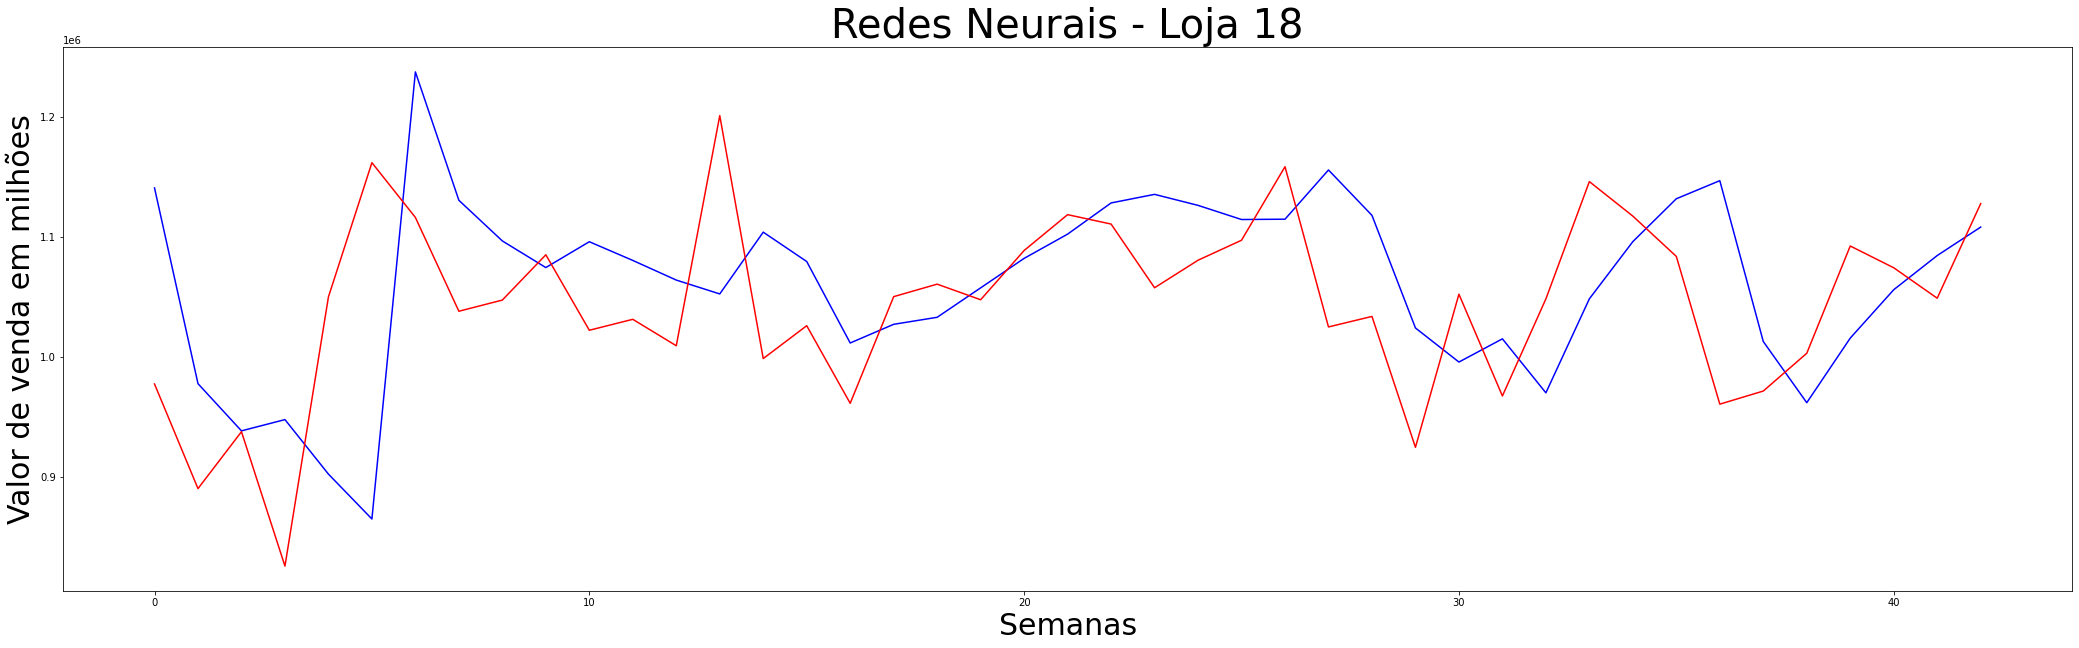

**************************************************
Resultados Loja 19:
-0.21151768778837732 77735.69 102426.68


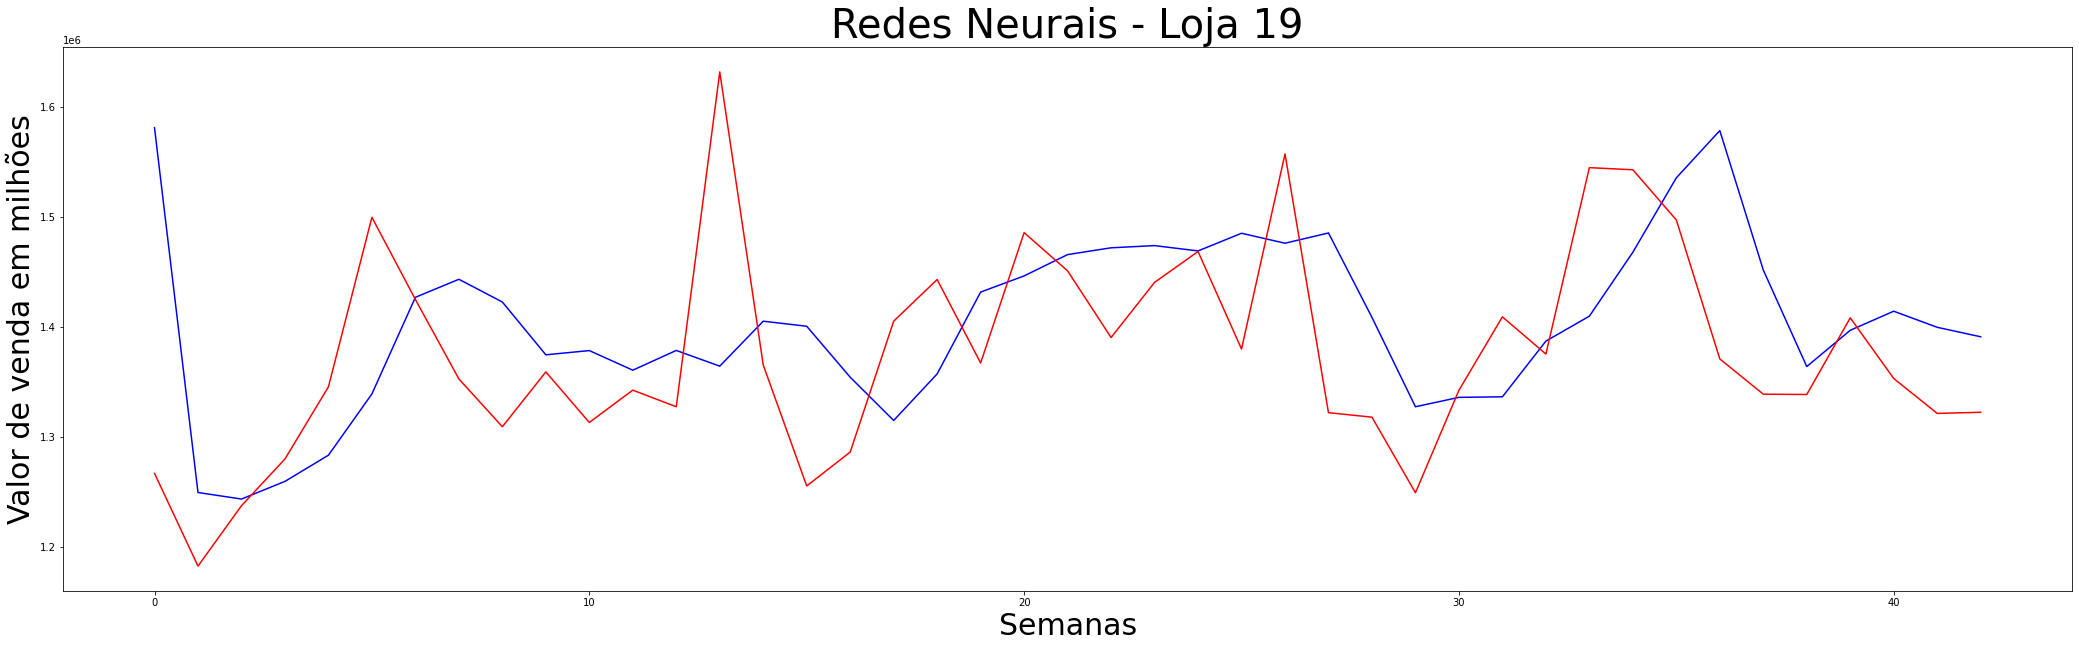

**************************************************
Resultados Loja 20:
-0.5663831872714848 153116.38 186650.62


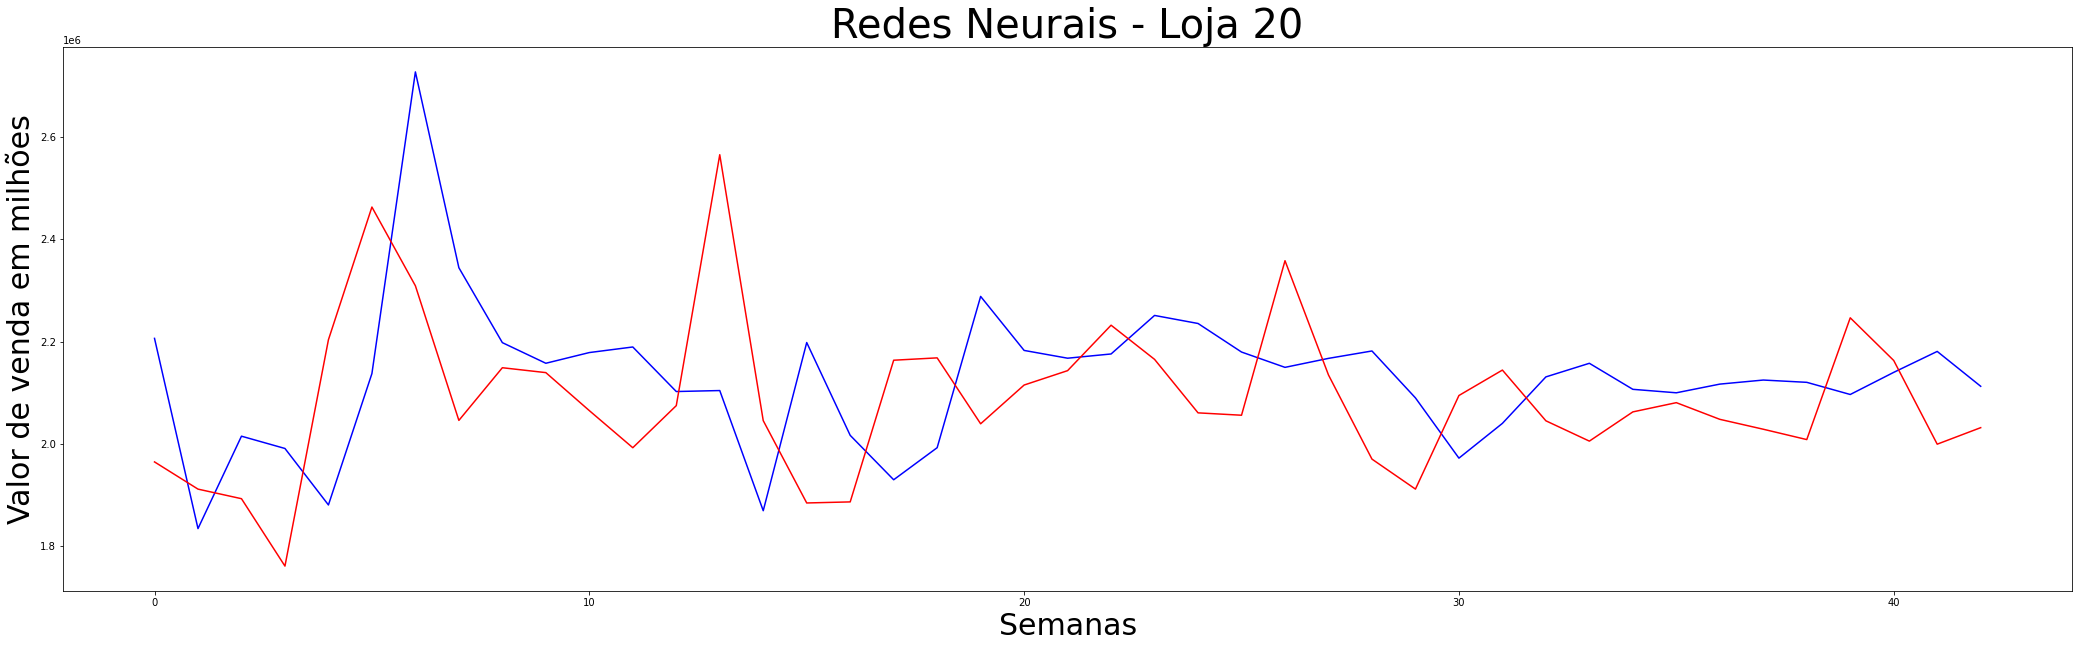

**************************************************
Resultados Loja 21:
-1.0902273271184928 45430.15 73971.25


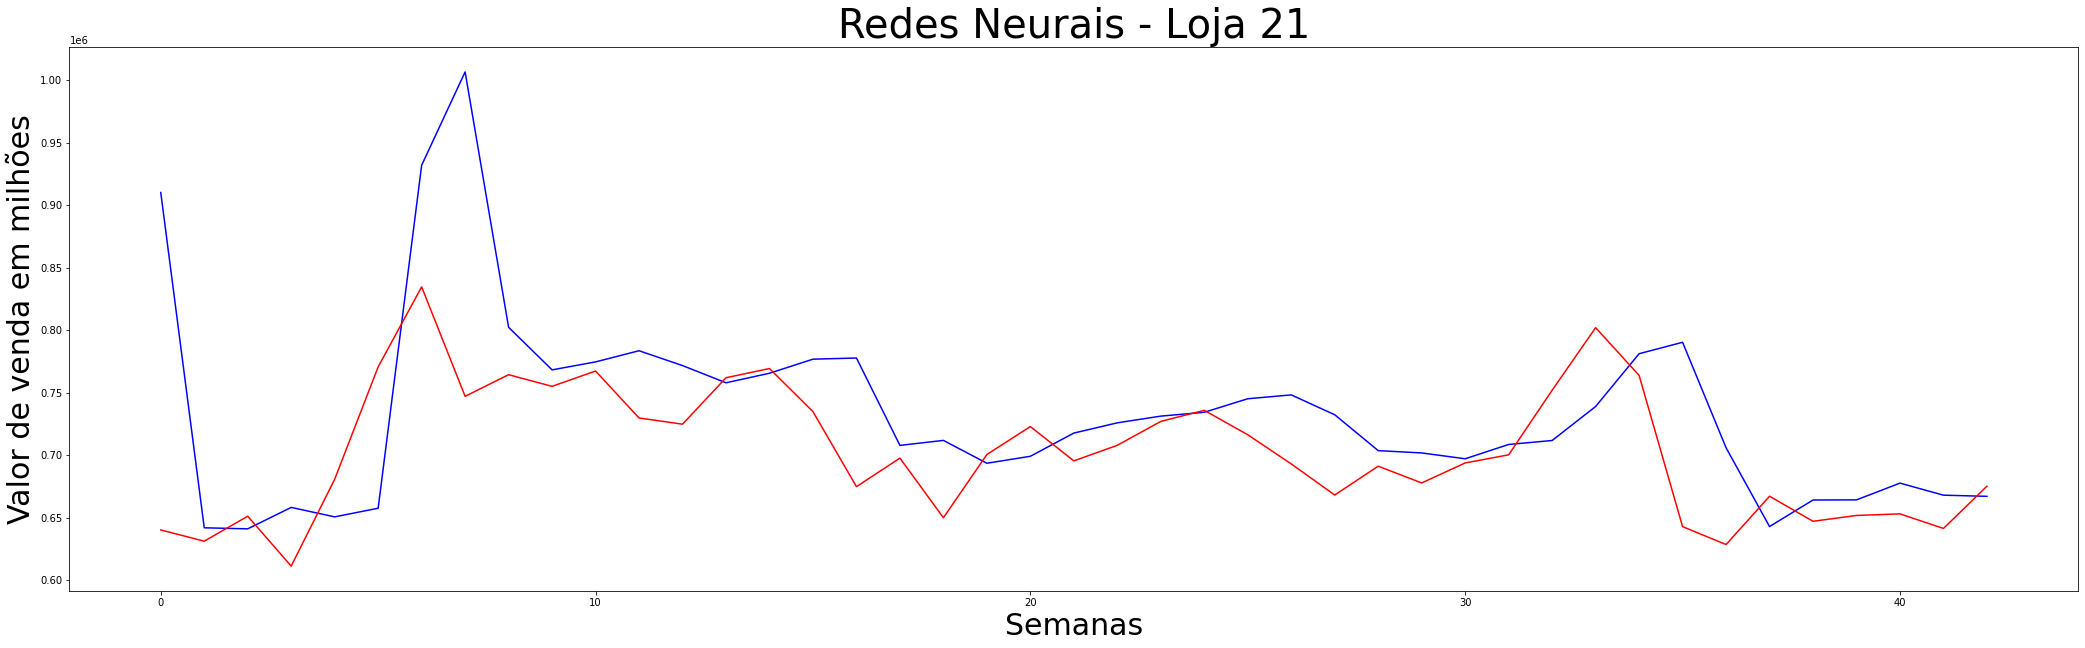

**************************************************
Resultados Loja 22:
-0.3314816641843601 59892.246 83987.336


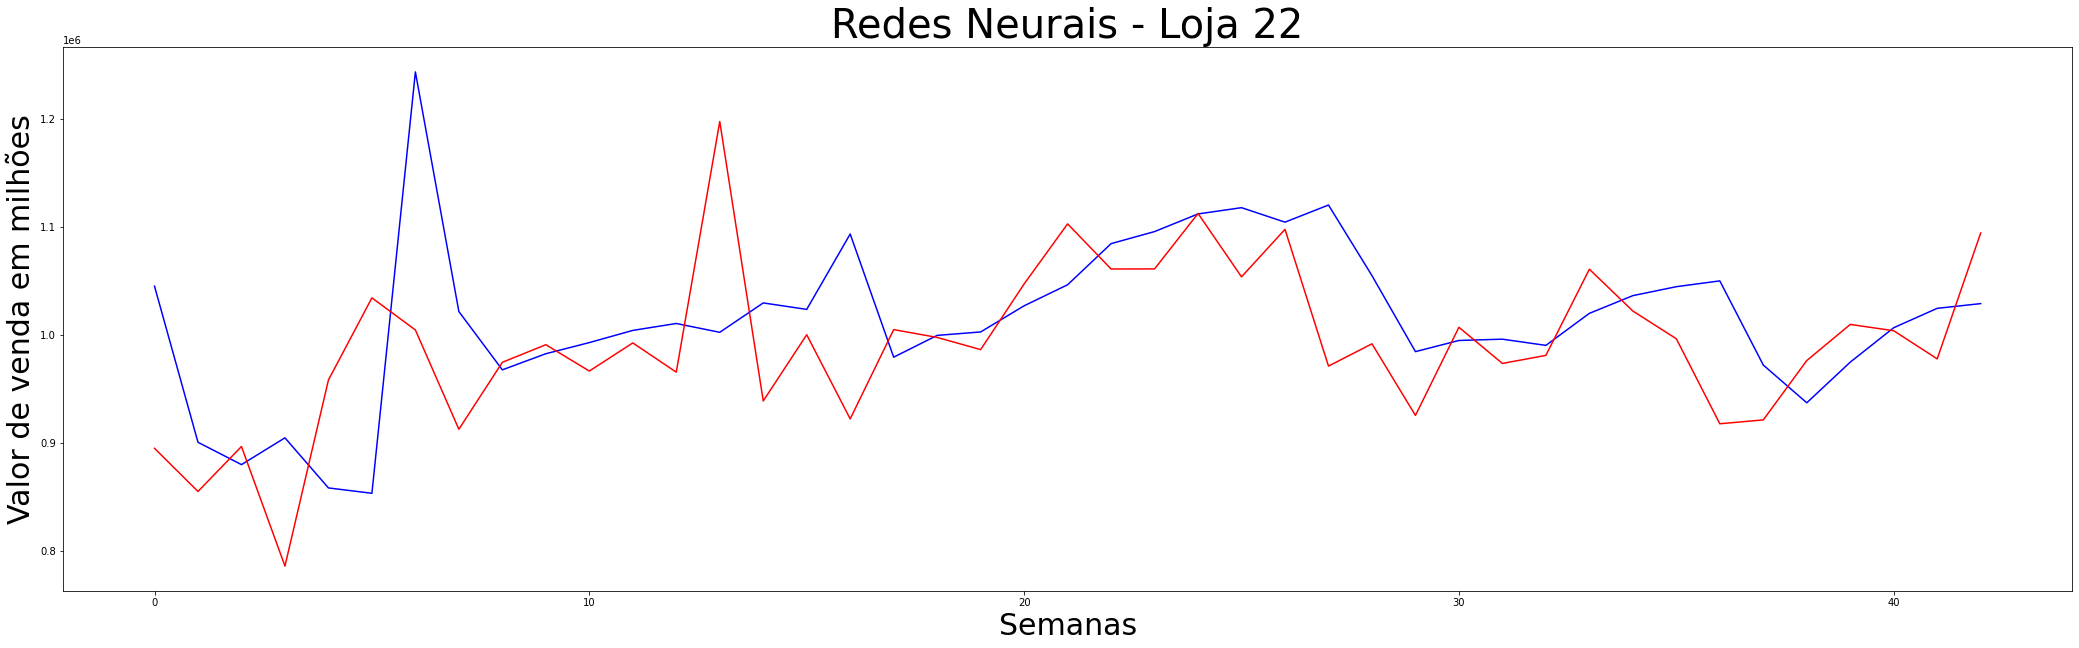

**************************************************
Resultados Loja 23:
0.3131163468794337 91424.01 117348.805


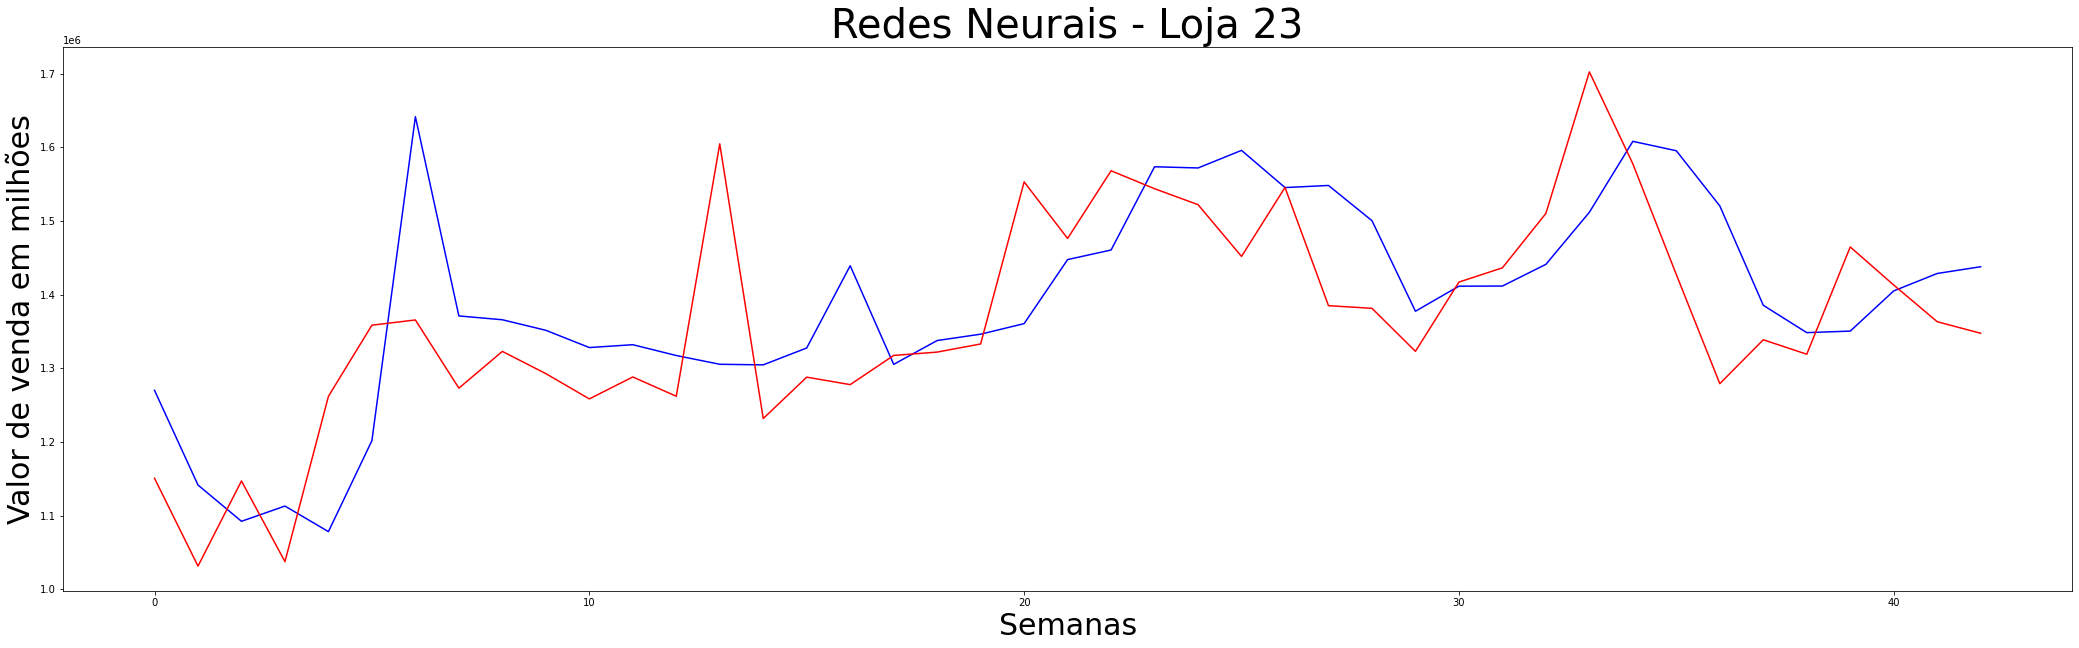

**************************************************
Resultados Loja 24:
-0.5144857328657437 104163.375 138143.25


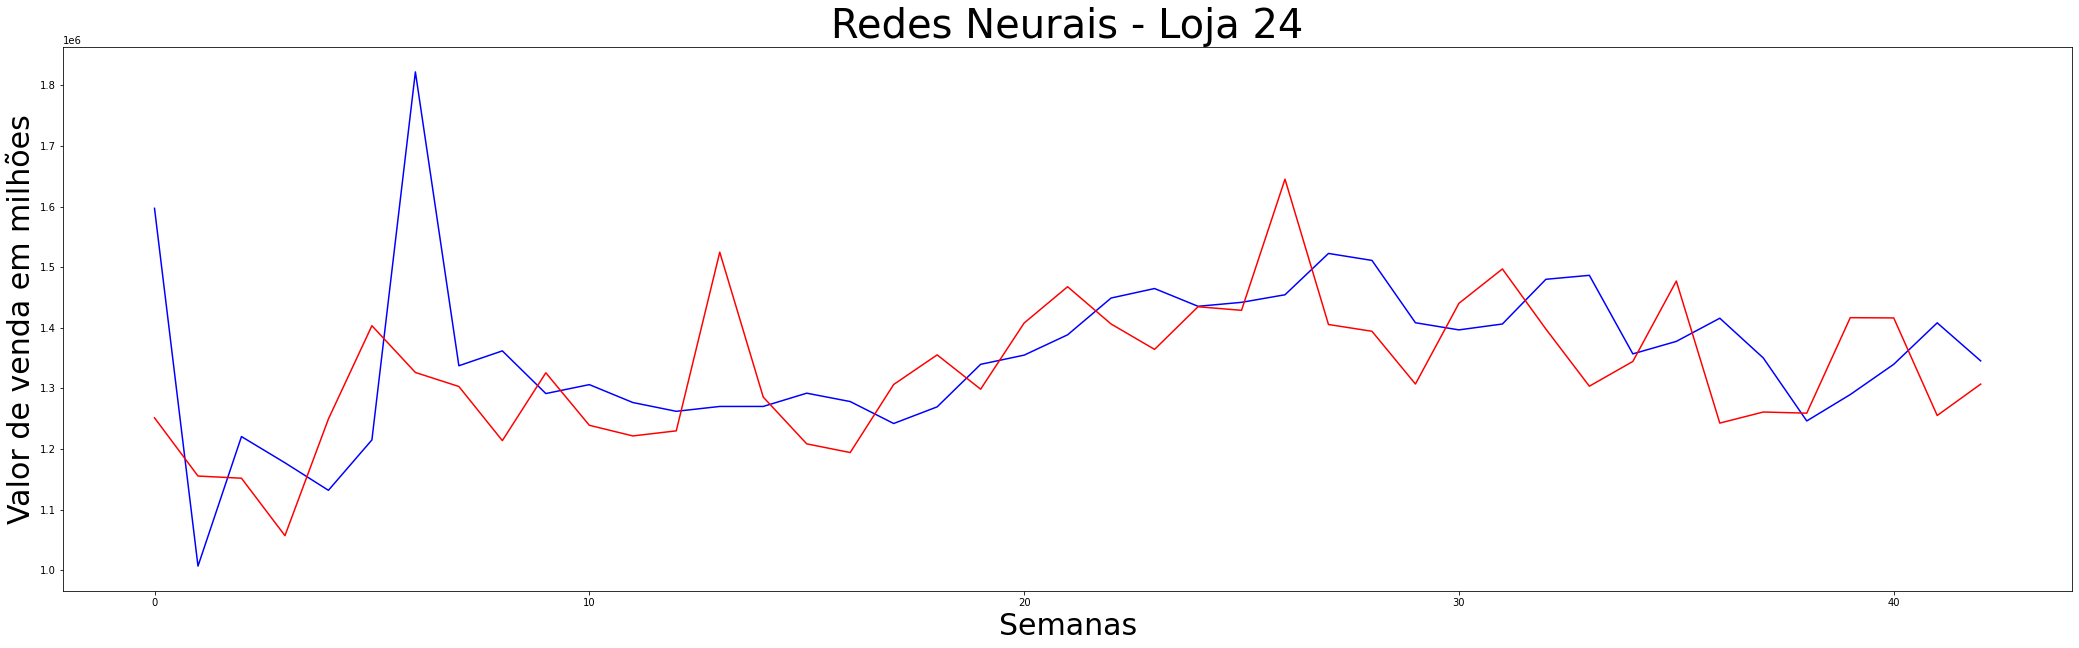

**************************************************
Resultados Loja 25:
0.2366258107456225 31743.174 40547.184


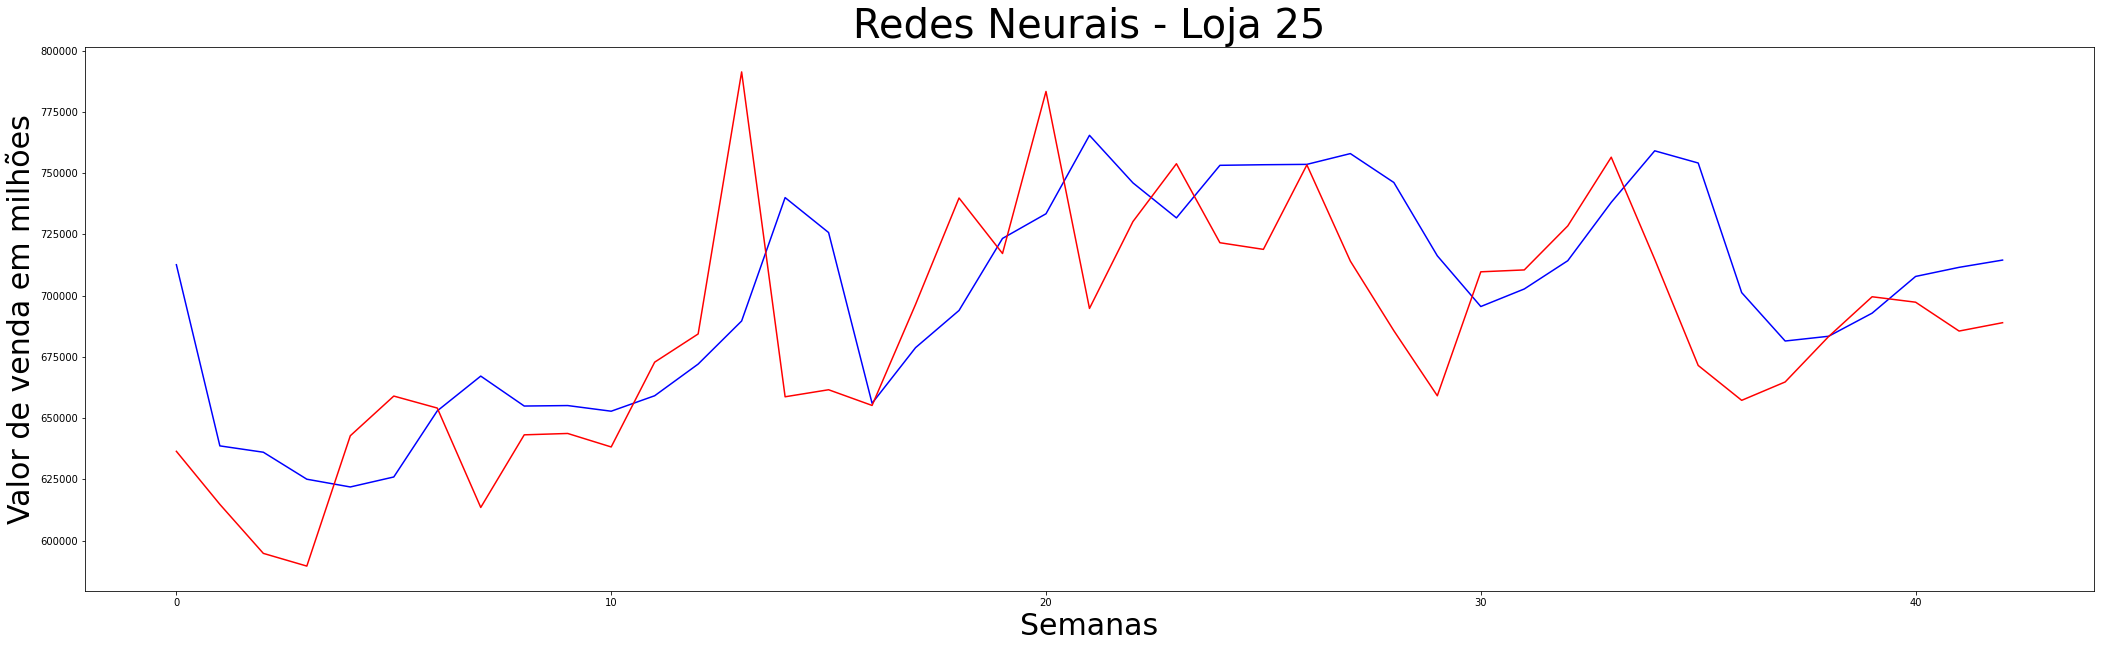

**************************************************
Resultados Loja 26:
-0.5954076762197471 73921.31 105271.17


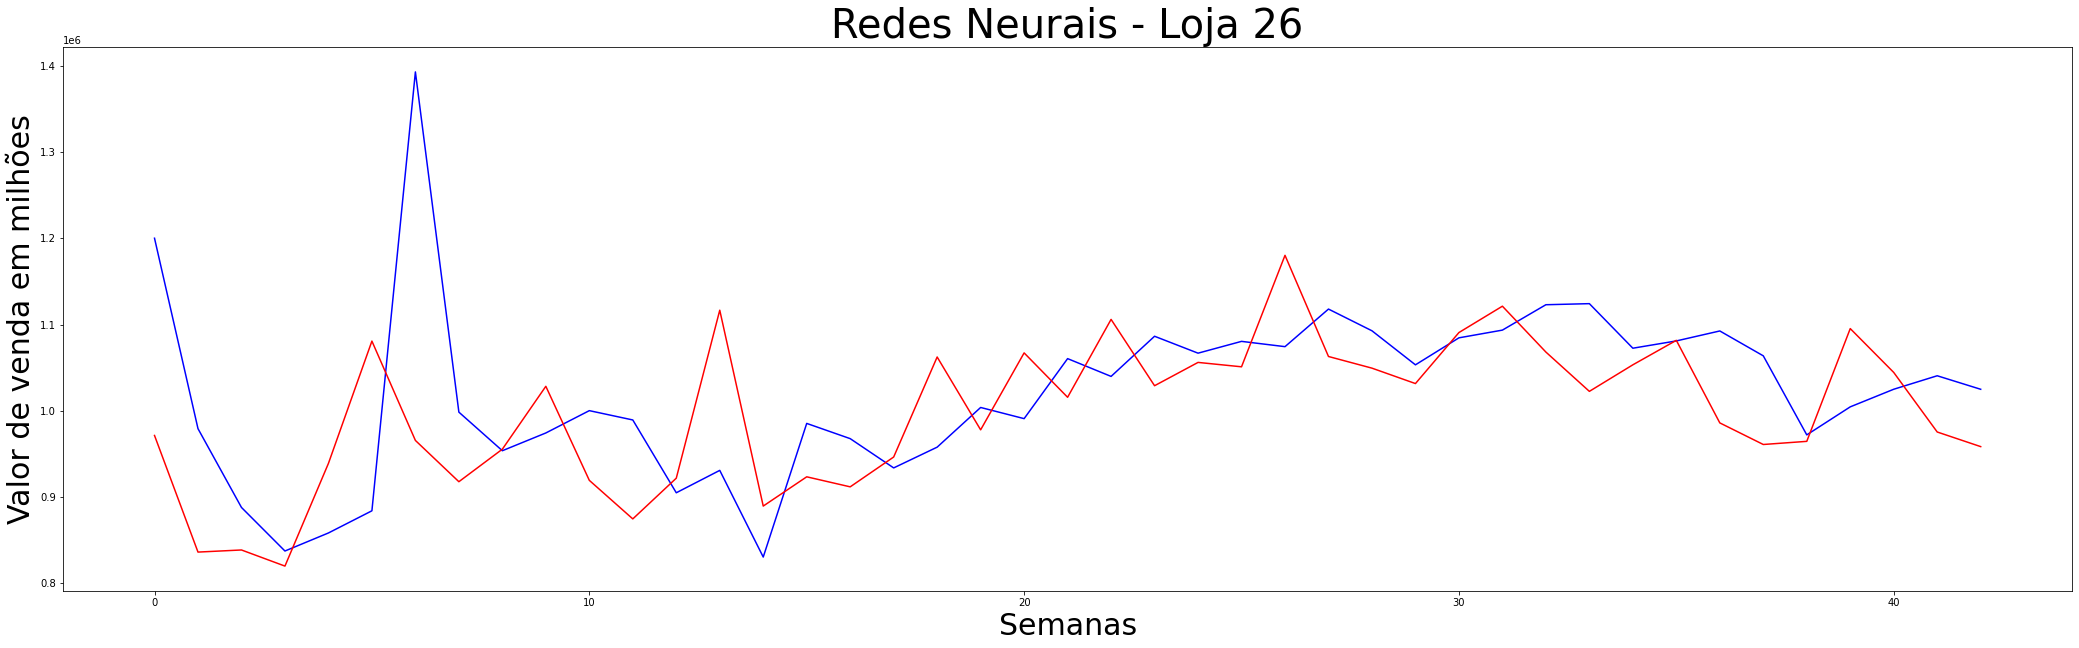

**************************************************
Resultados Loja 27:
0.02695748635258499 92722.59 133228.1


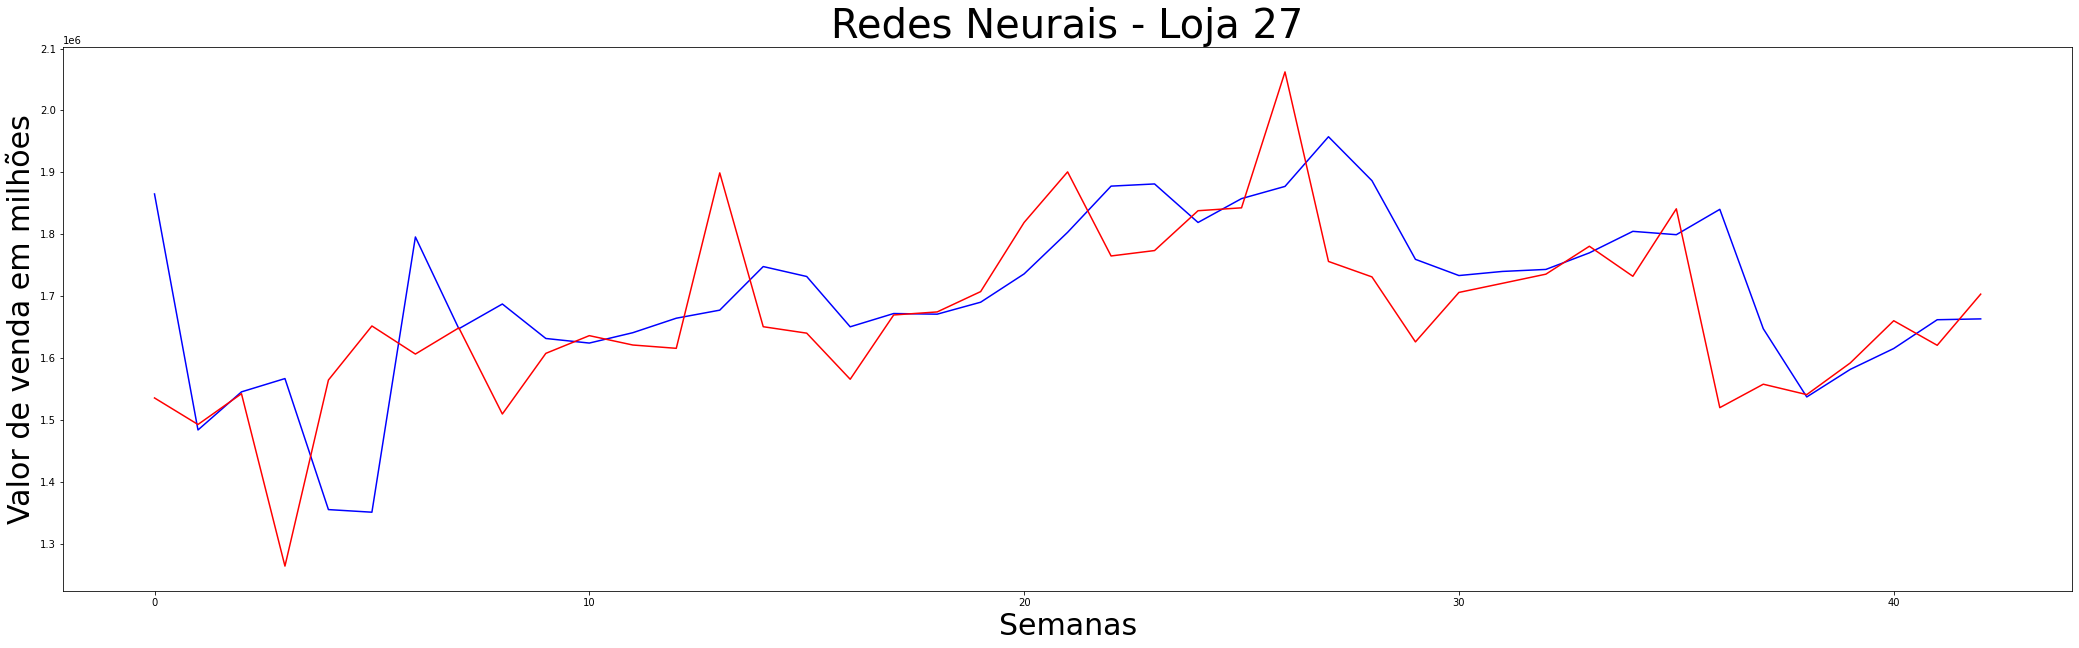

**************************************************
Resultados Loja 28:
-1.2768394096582583 171310.3 229737.56


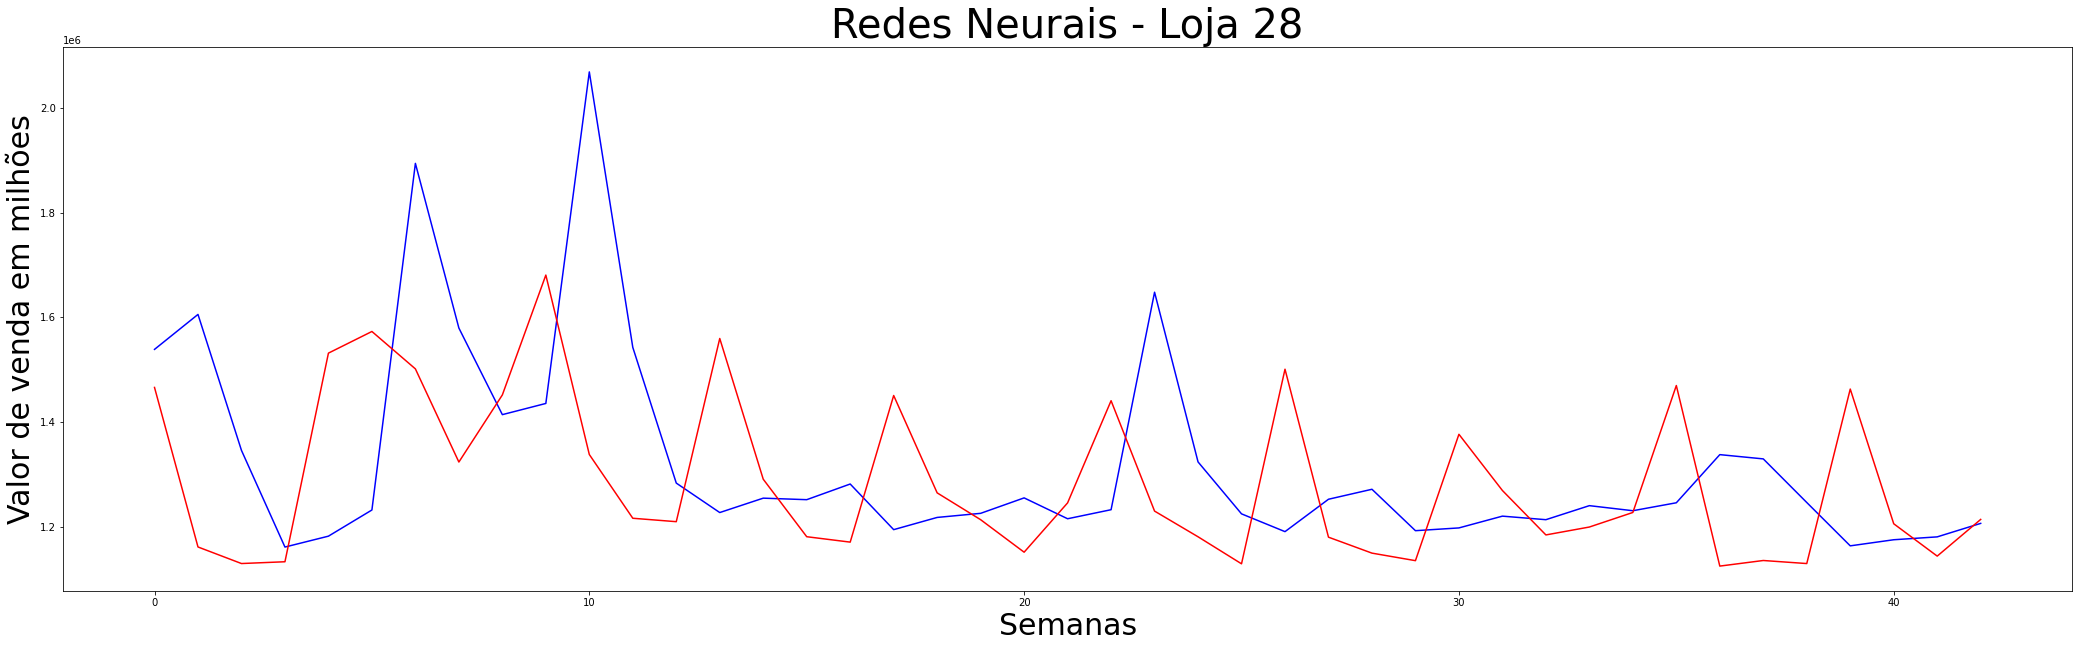

**************************************************
Resultados Loja 29:
-0.4208290013914373 36891.1 54809.258


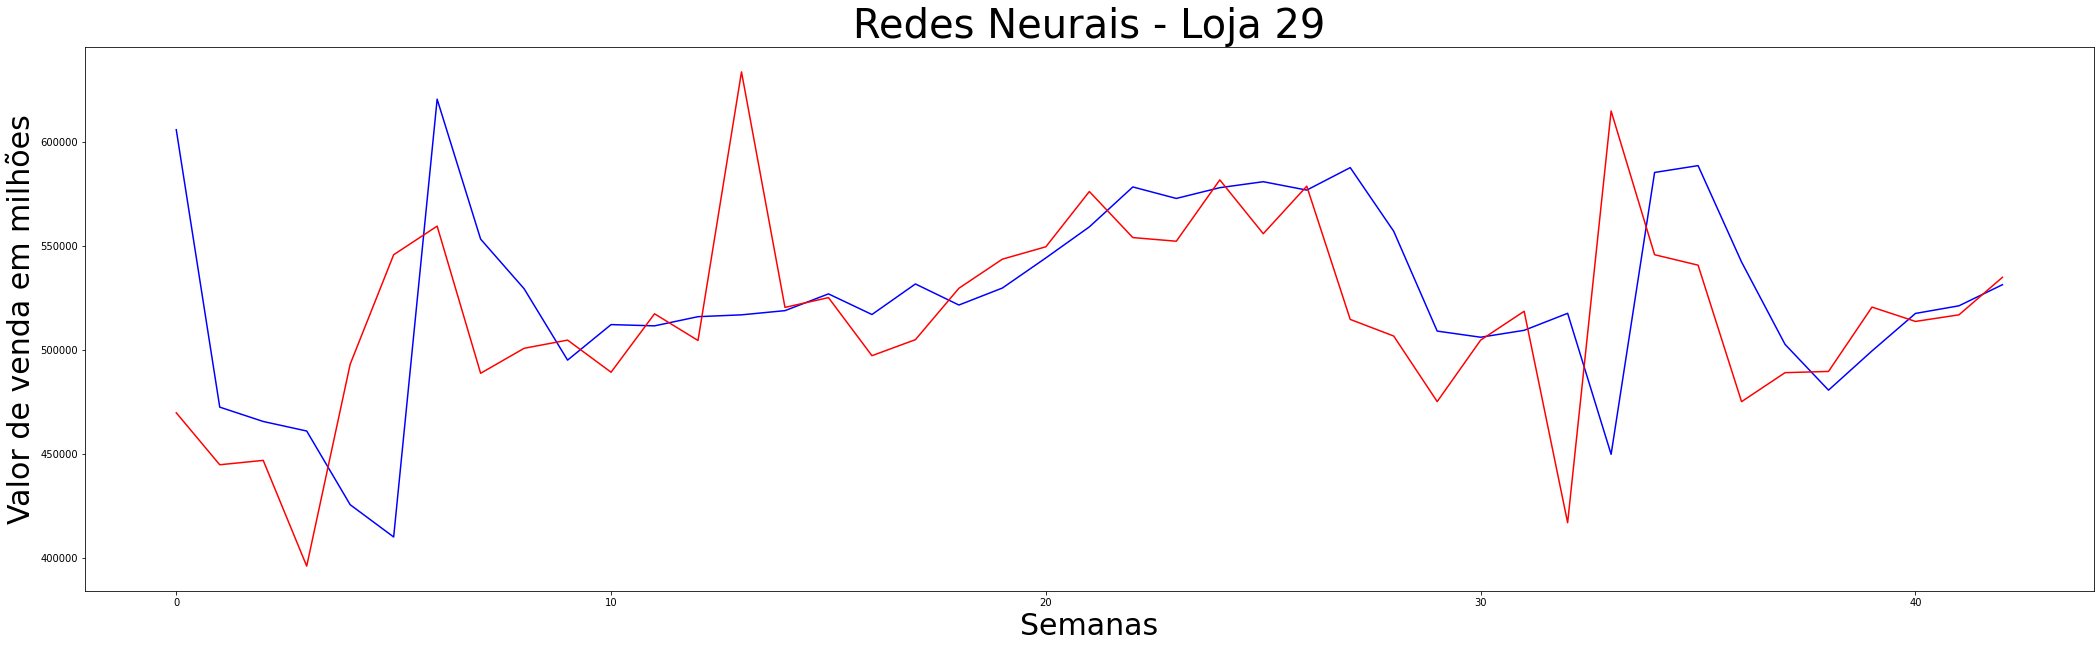

**************************************************
Resultados Loja 30:
-1.452703104205506 14777.947 18360.316


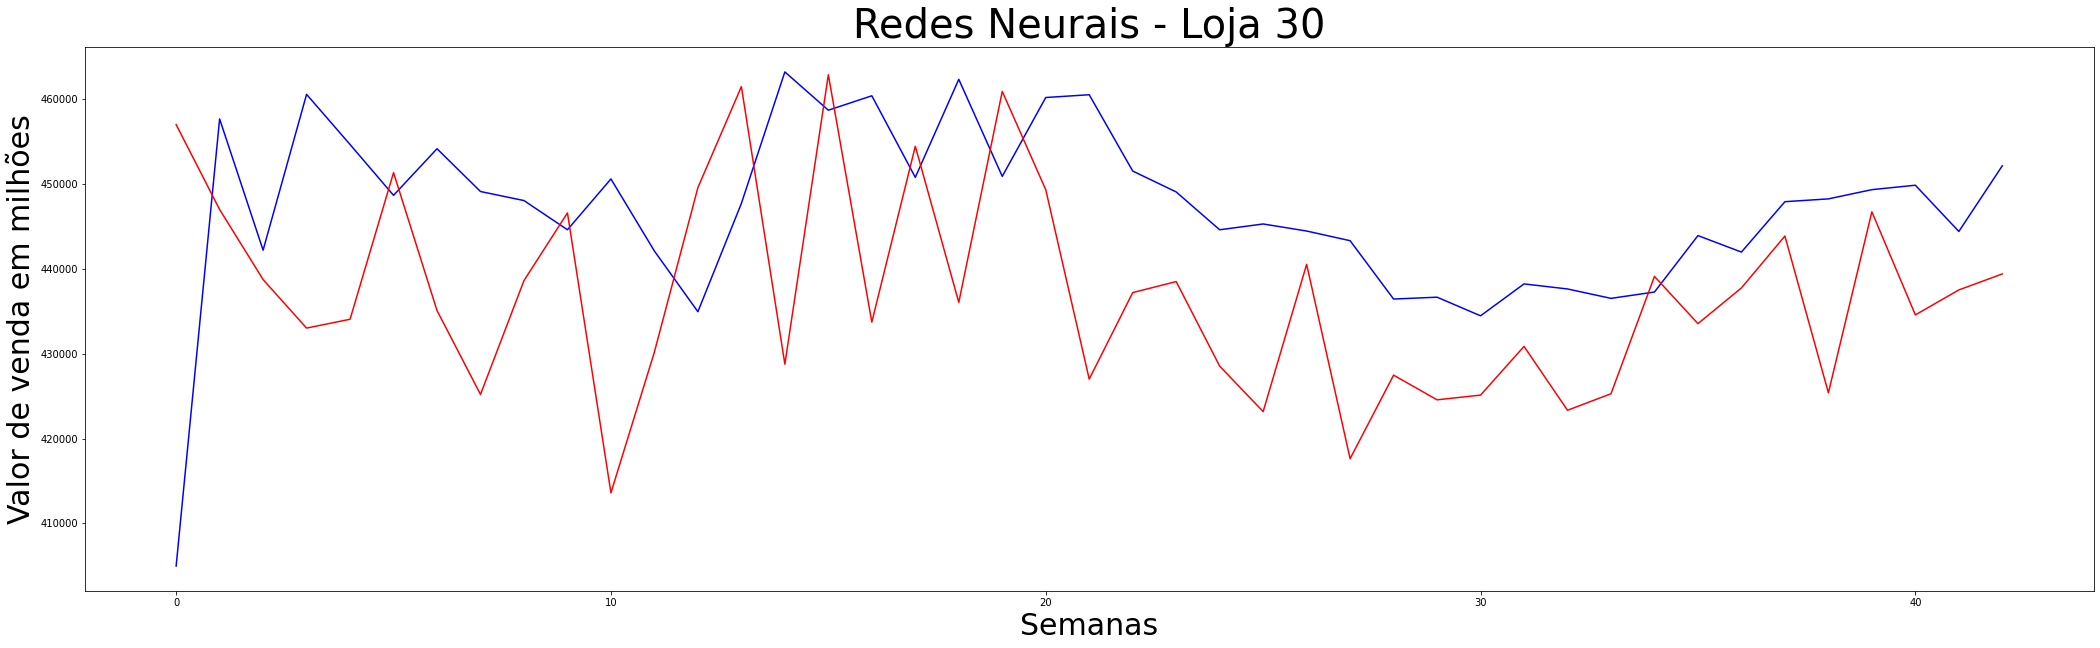

**************************************************
Resultados Loja 31:
-1.6031383913602864 71668.88 94652.21


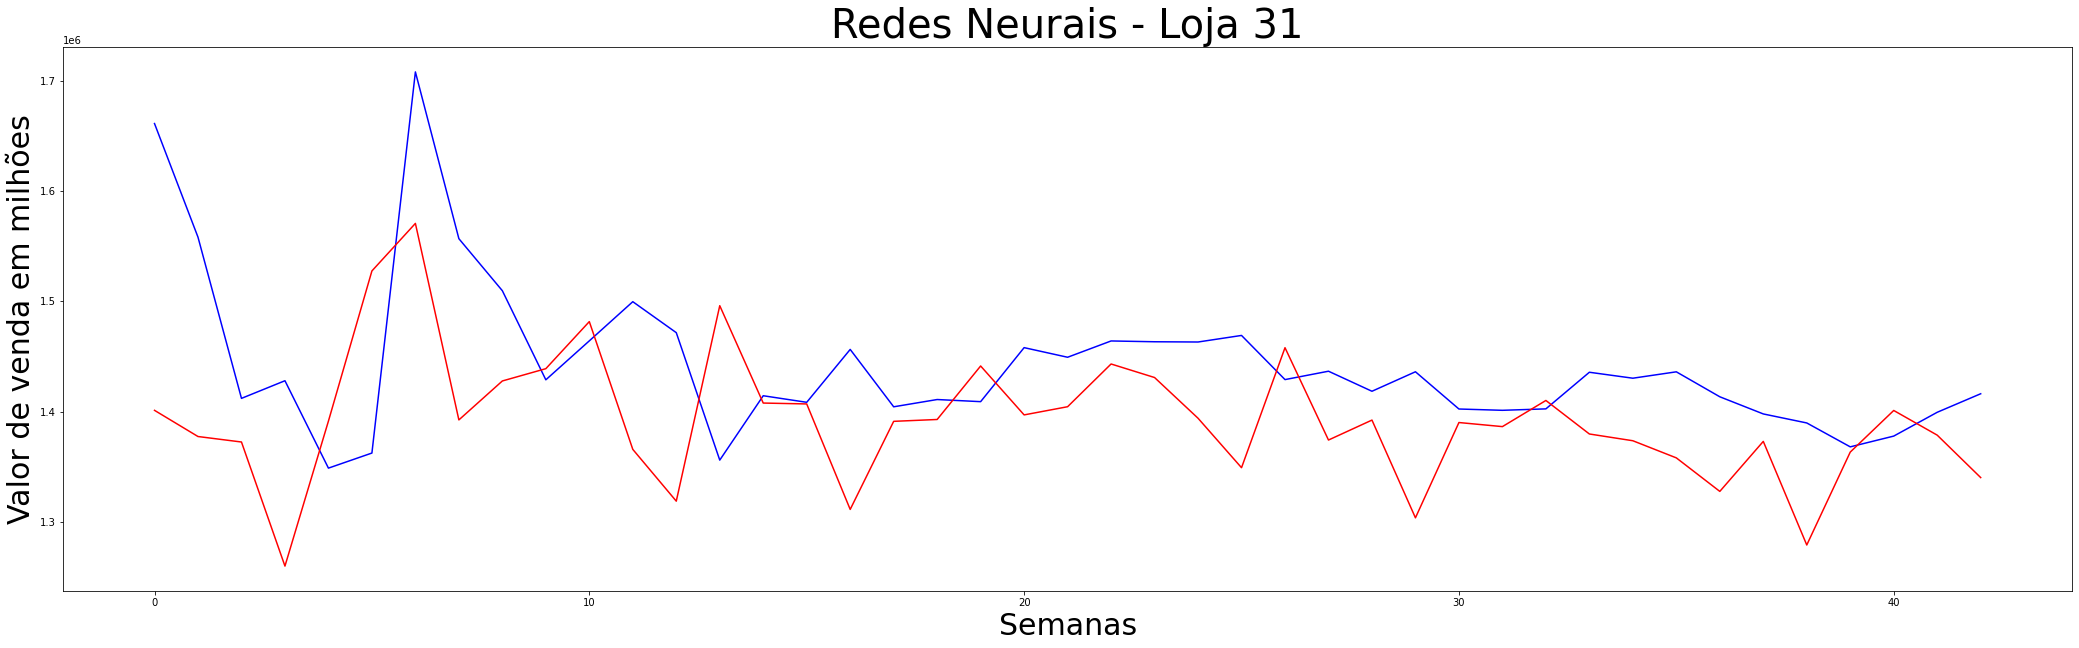

**************************************************
Resultados Loja 32:
-0.08964742027257389 42459.234 55233.39


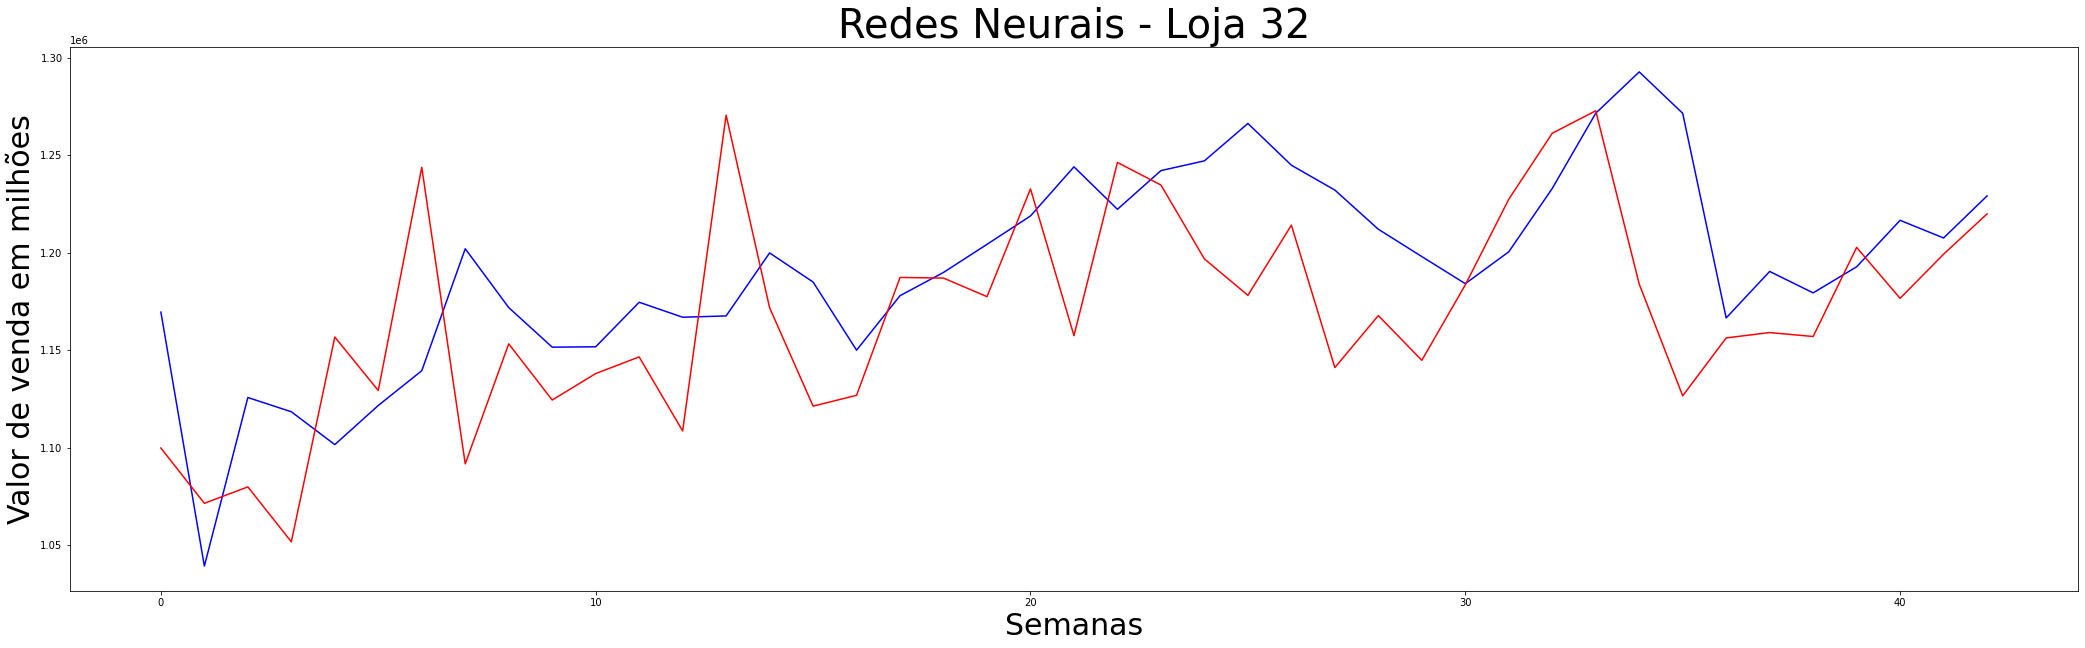

**************************************************
Resultados Loja 33:
-2.0660577810072676 26097.643 32072.805


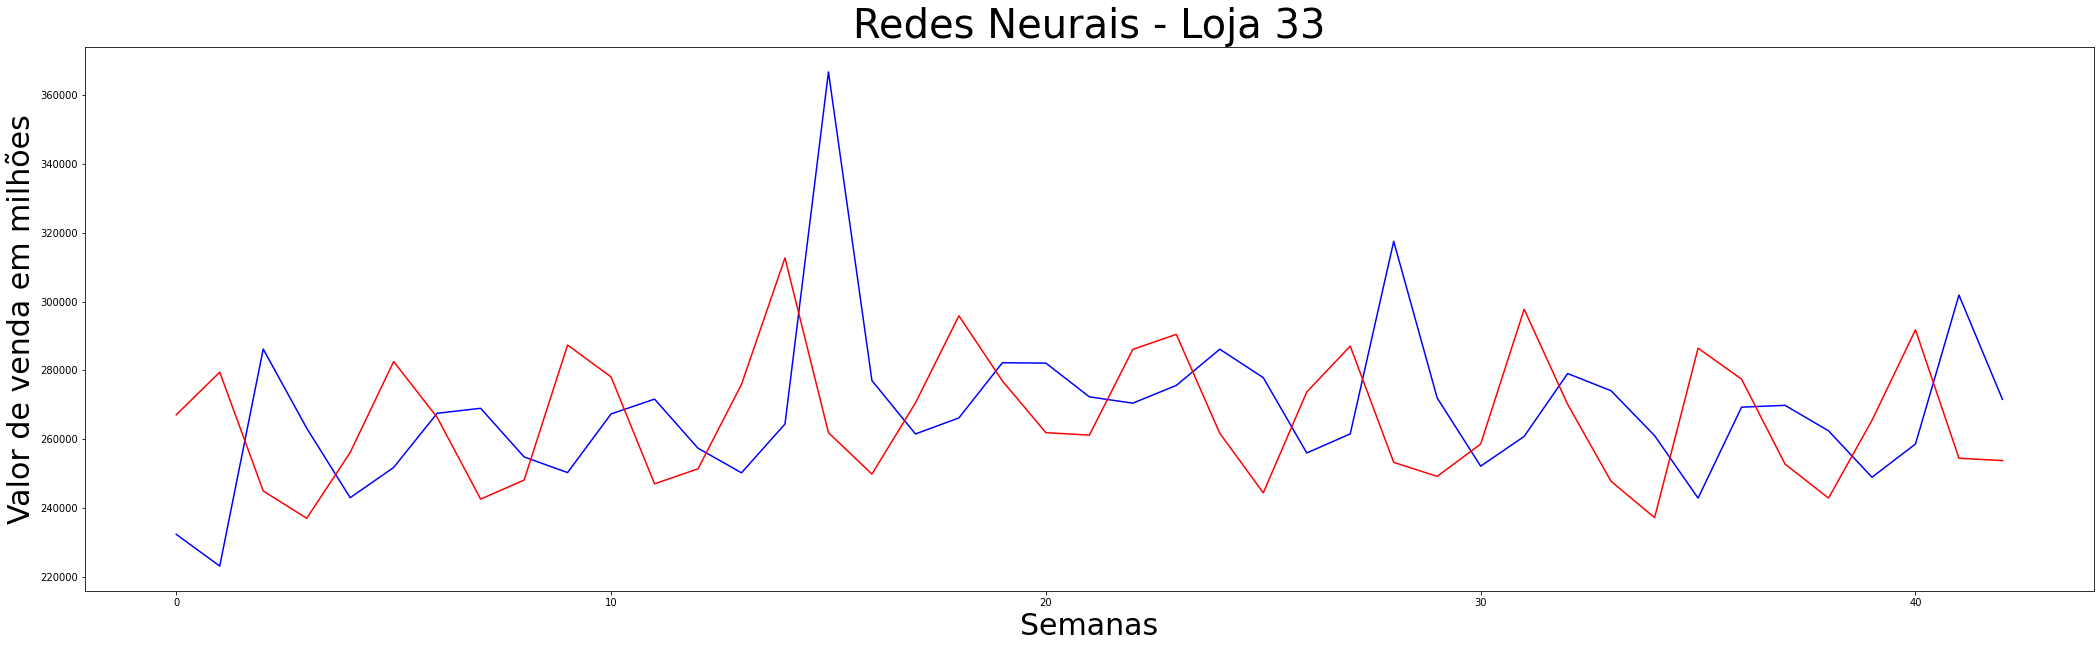

**************************************************
Resultados Loja 34:
-1.801678663339557 50423.18 75327.96


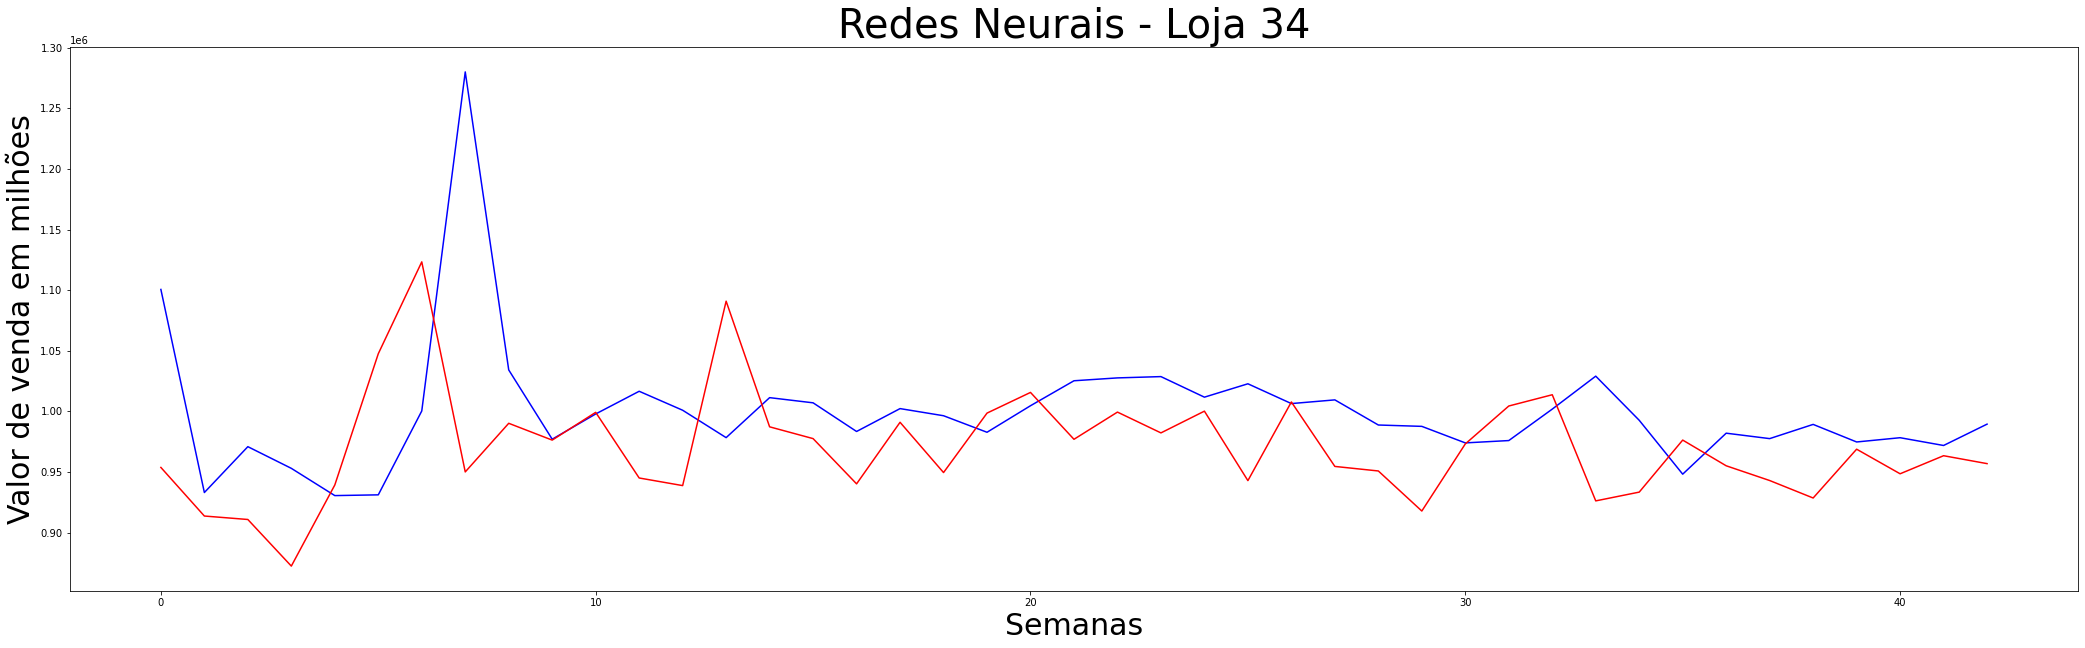

**************************************************
Resultados Loja 35:
-0.10695588578754966 56976.406 87202.68


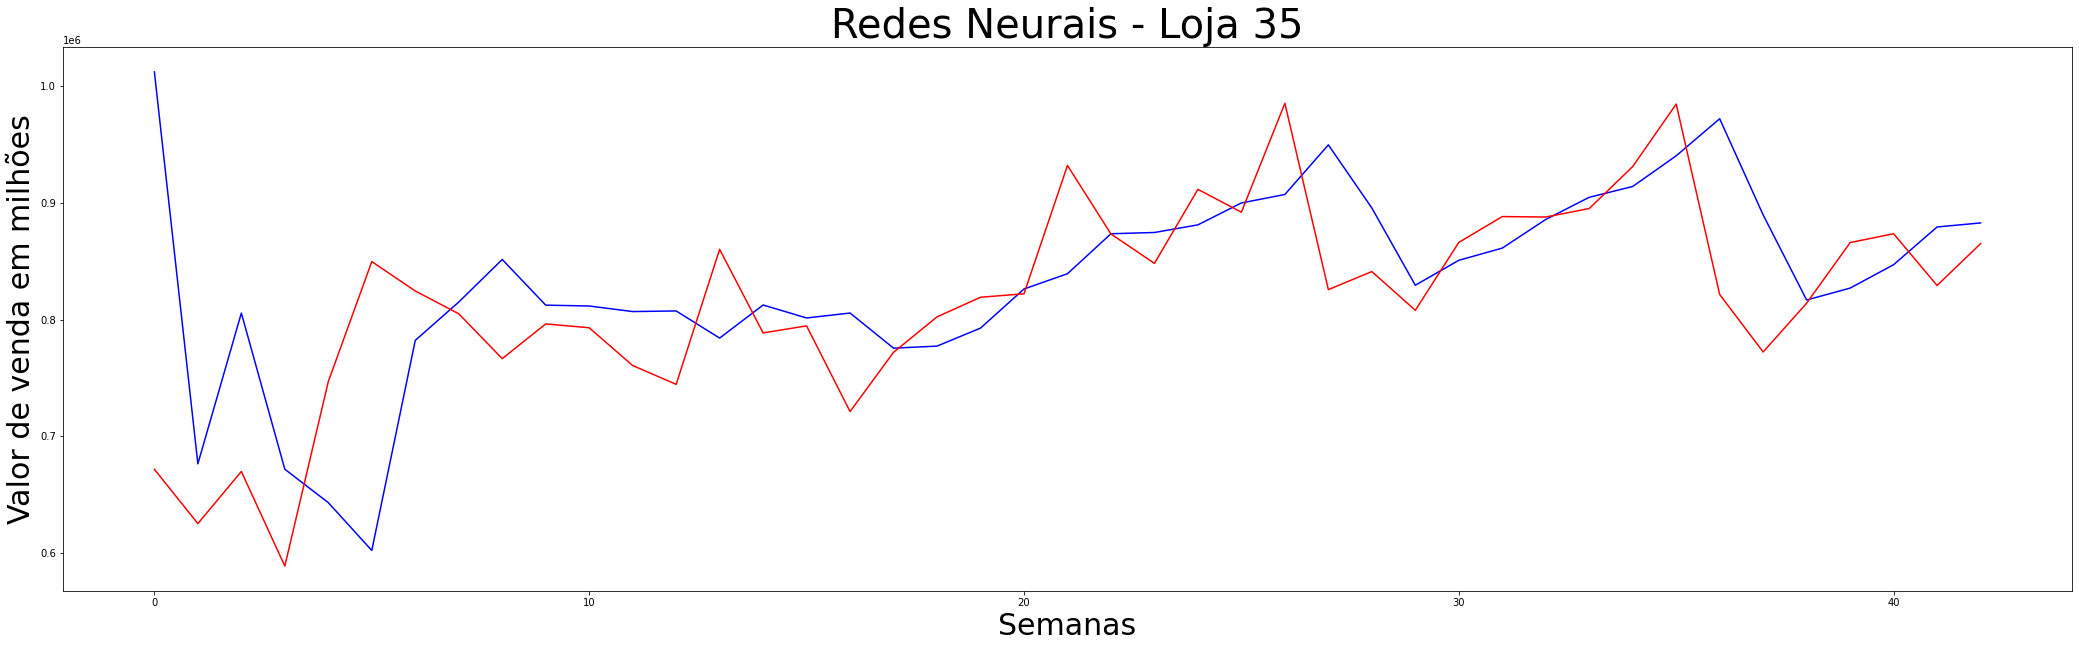

**************************************************
Resultados Loja 36:
0.09401363549659913 15159.2 17642.576


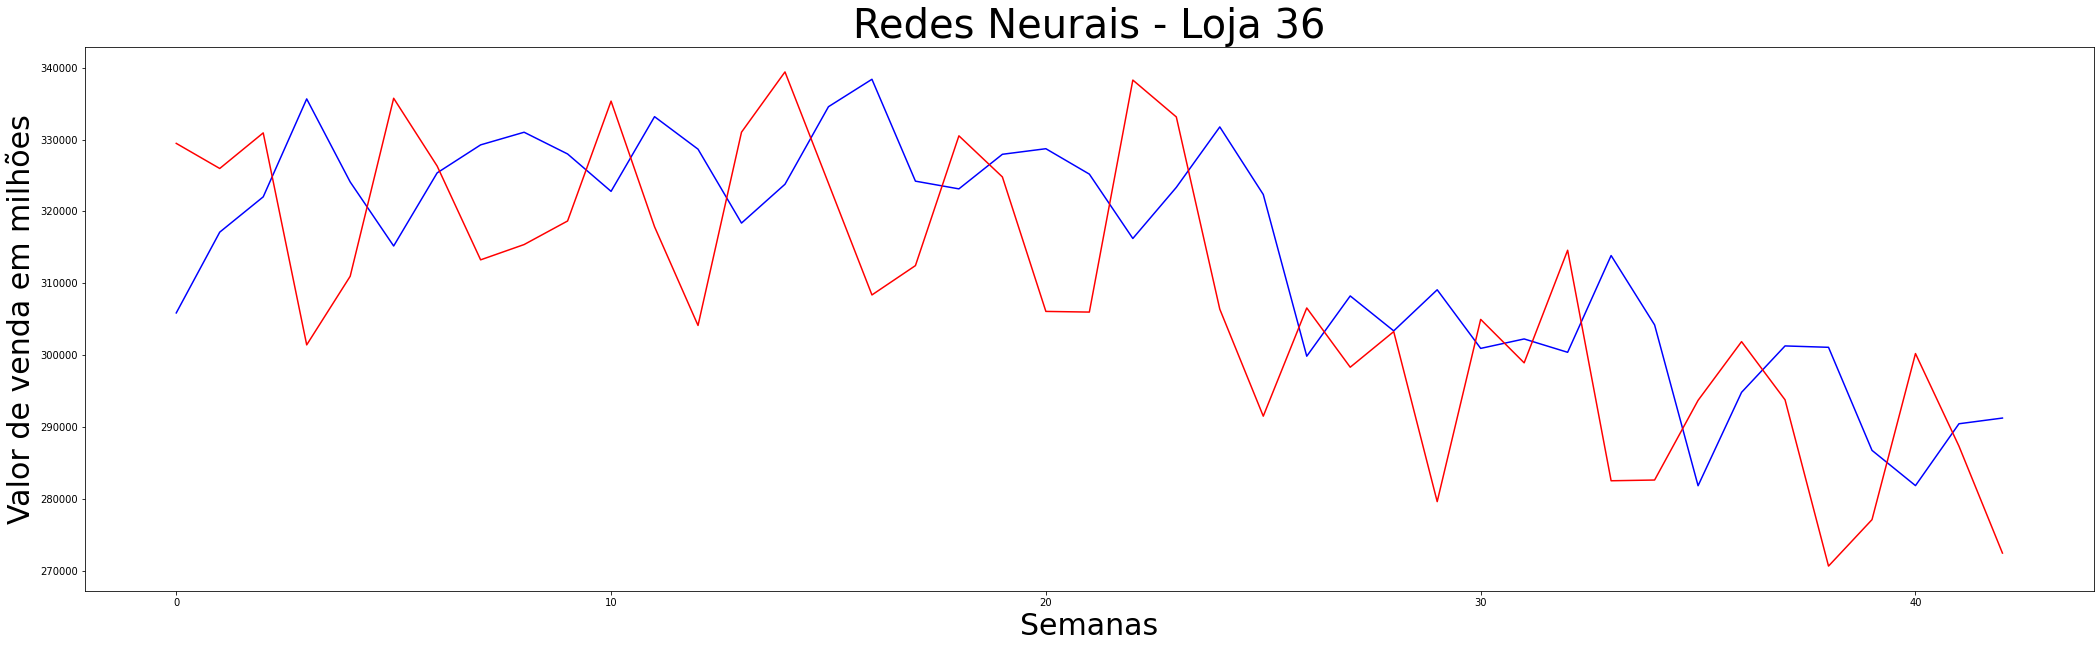

**************************************************
Resultados Loja 37:
-1.14784249446073 19417.275 25603.85


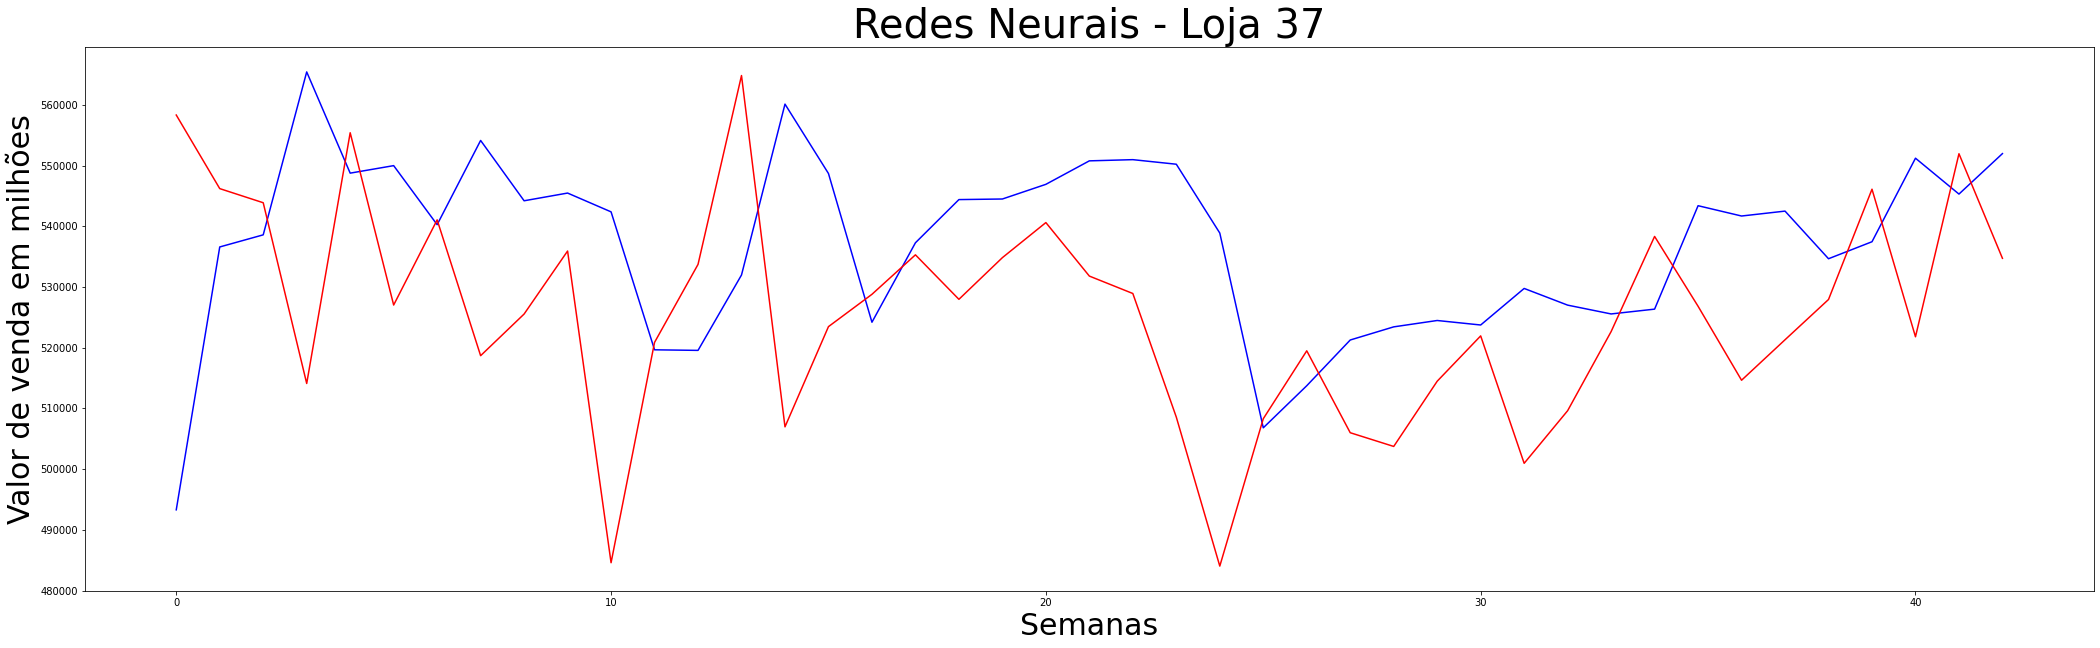

**************************************************
Resultados Loja 38:
-1.0075751352820355 30783.262 38601.234


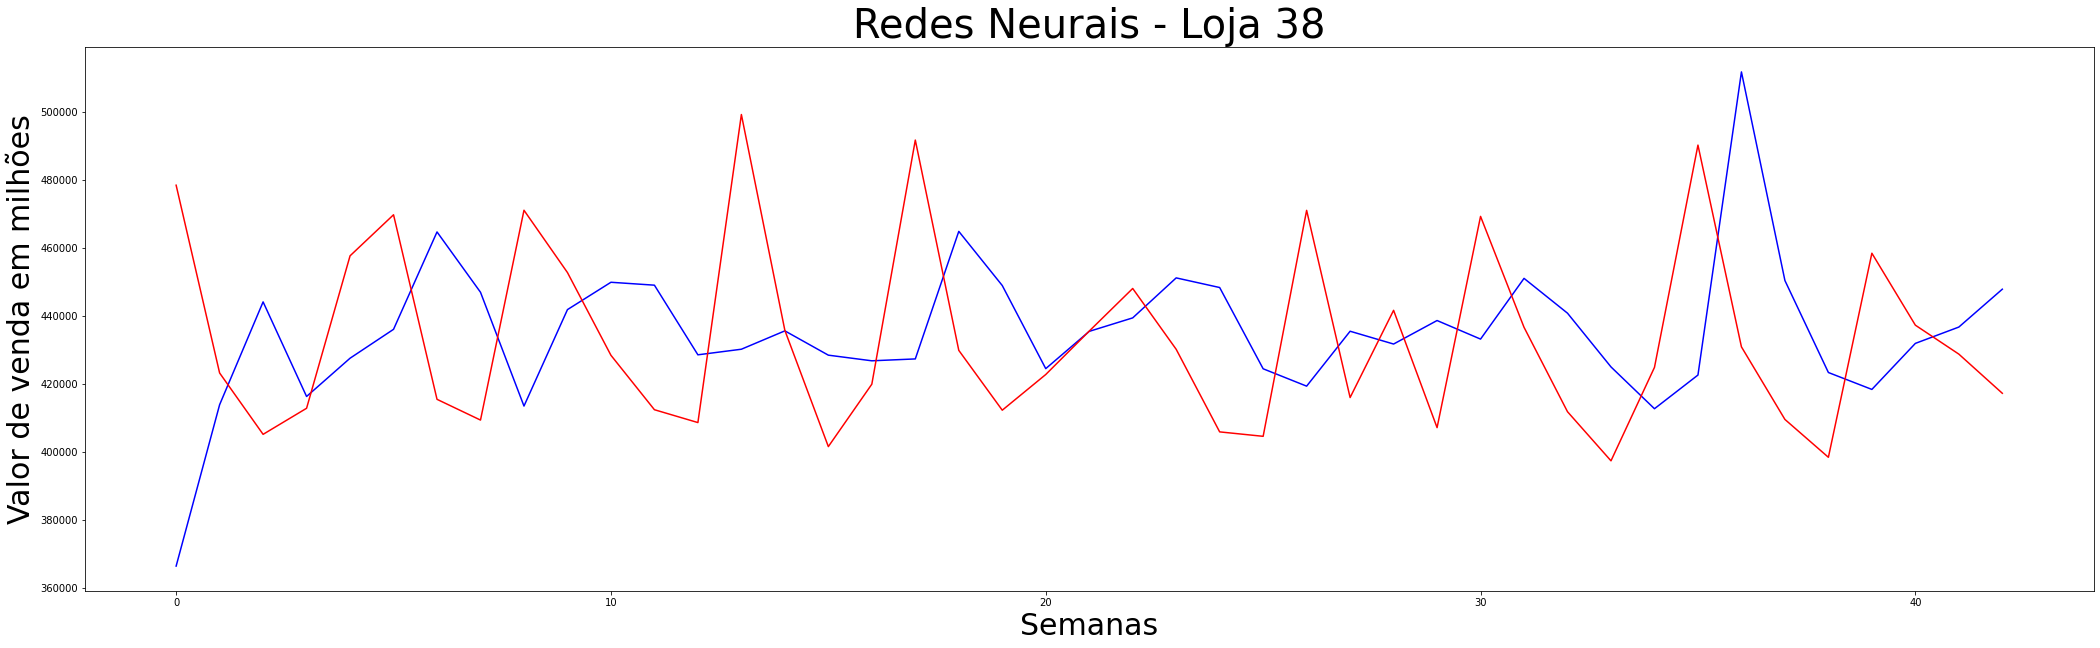

**************************************************
Resultados Loja 39:
0.04531059790402048 74218.15 96887.91


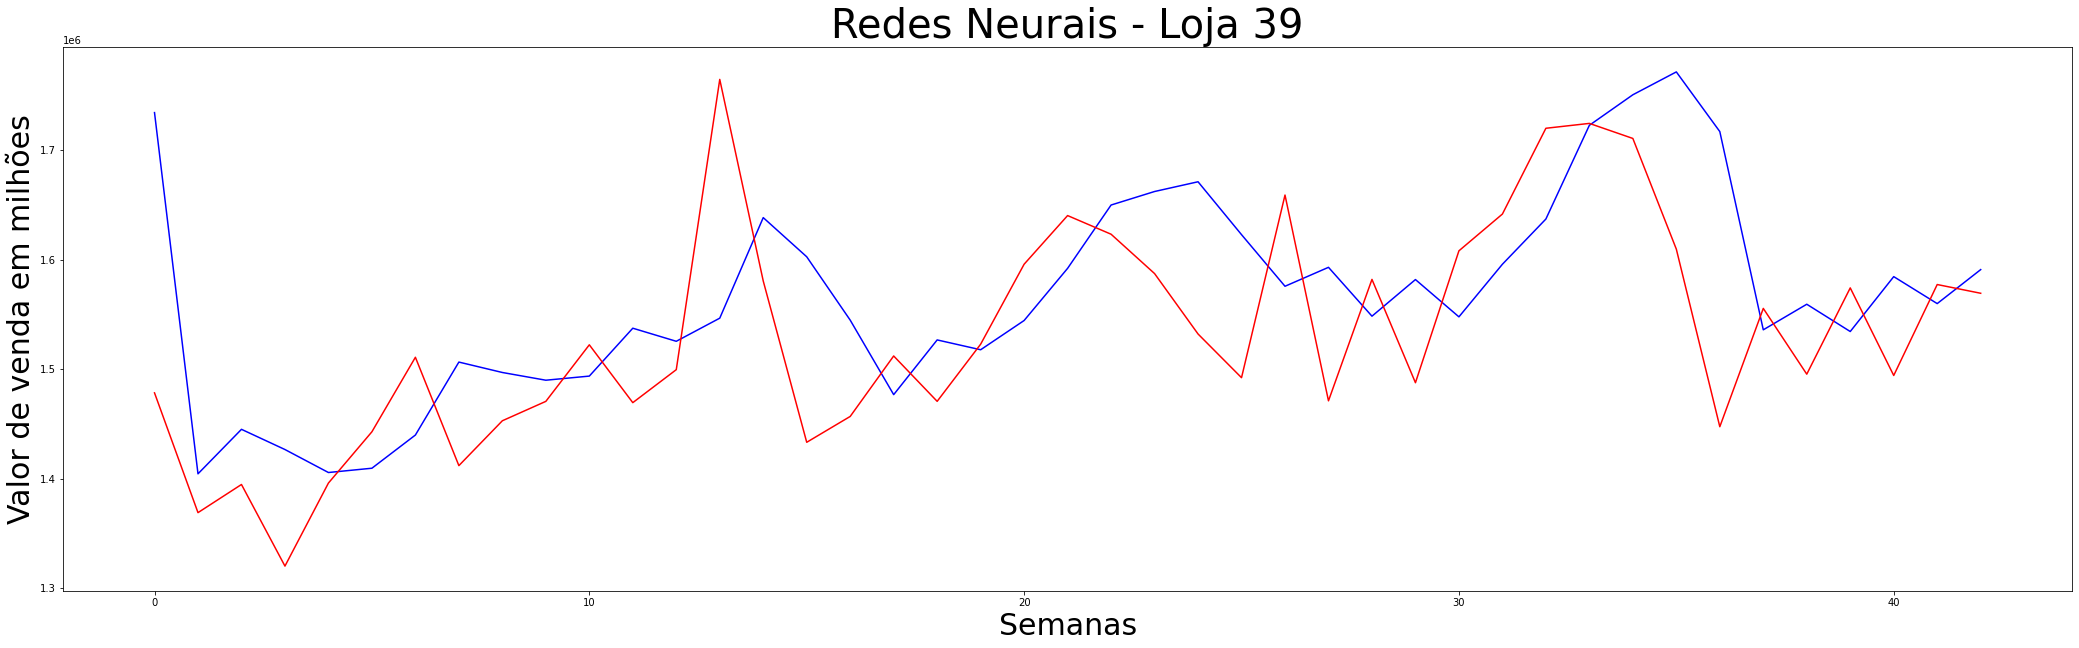

**************************************************
Resultados Loja 40:
-0.078578339334201 72690.56 88331.99


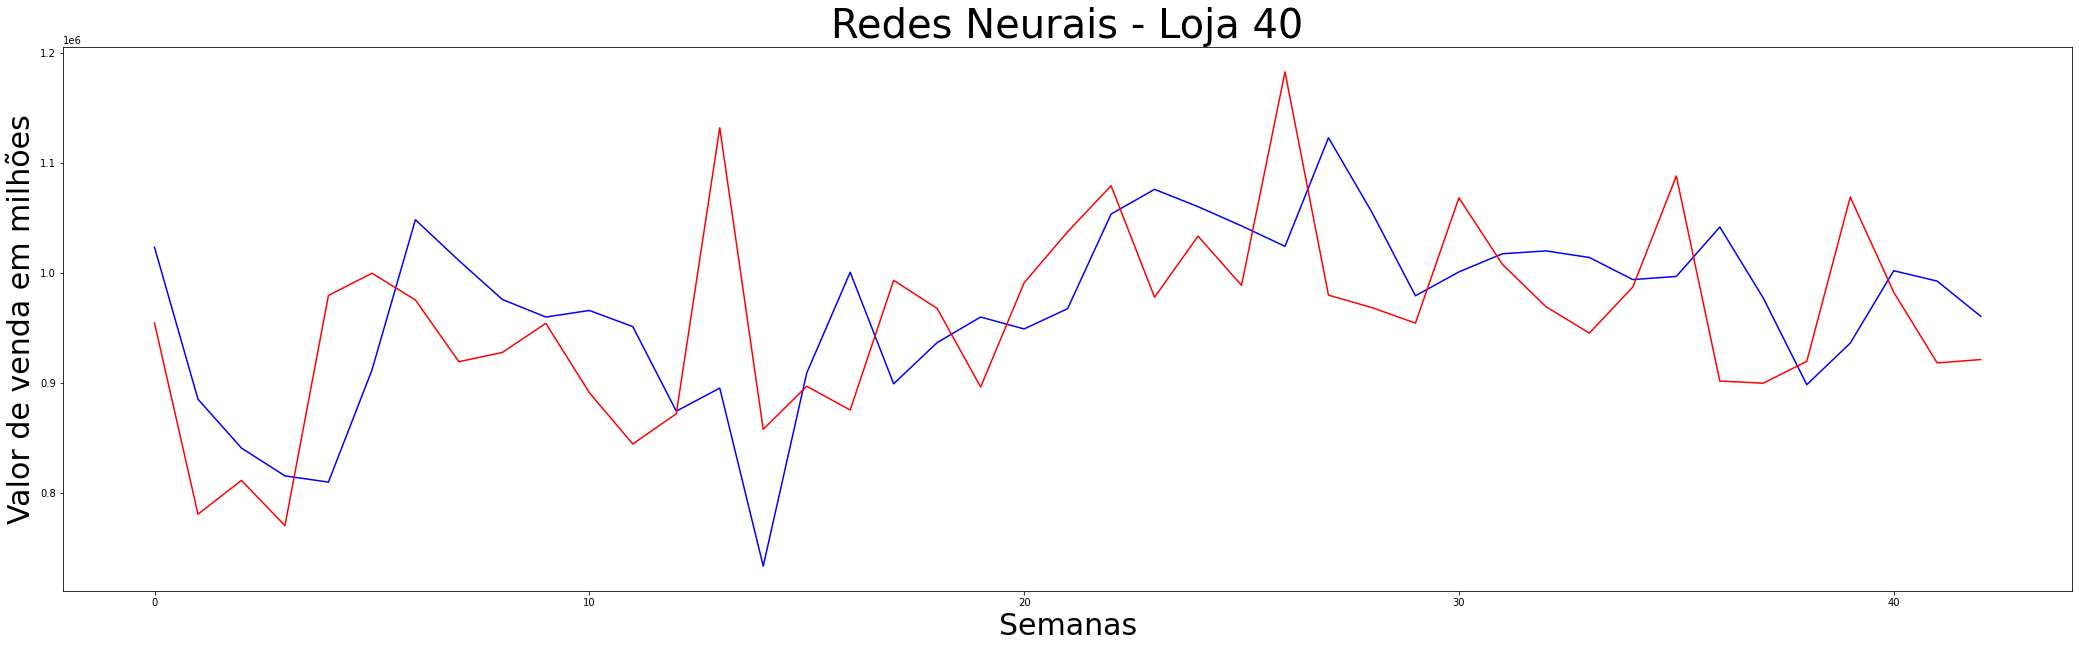

**************************************************
Resultados Loja 41:
0.3419739314766813 71257.695 84182.13


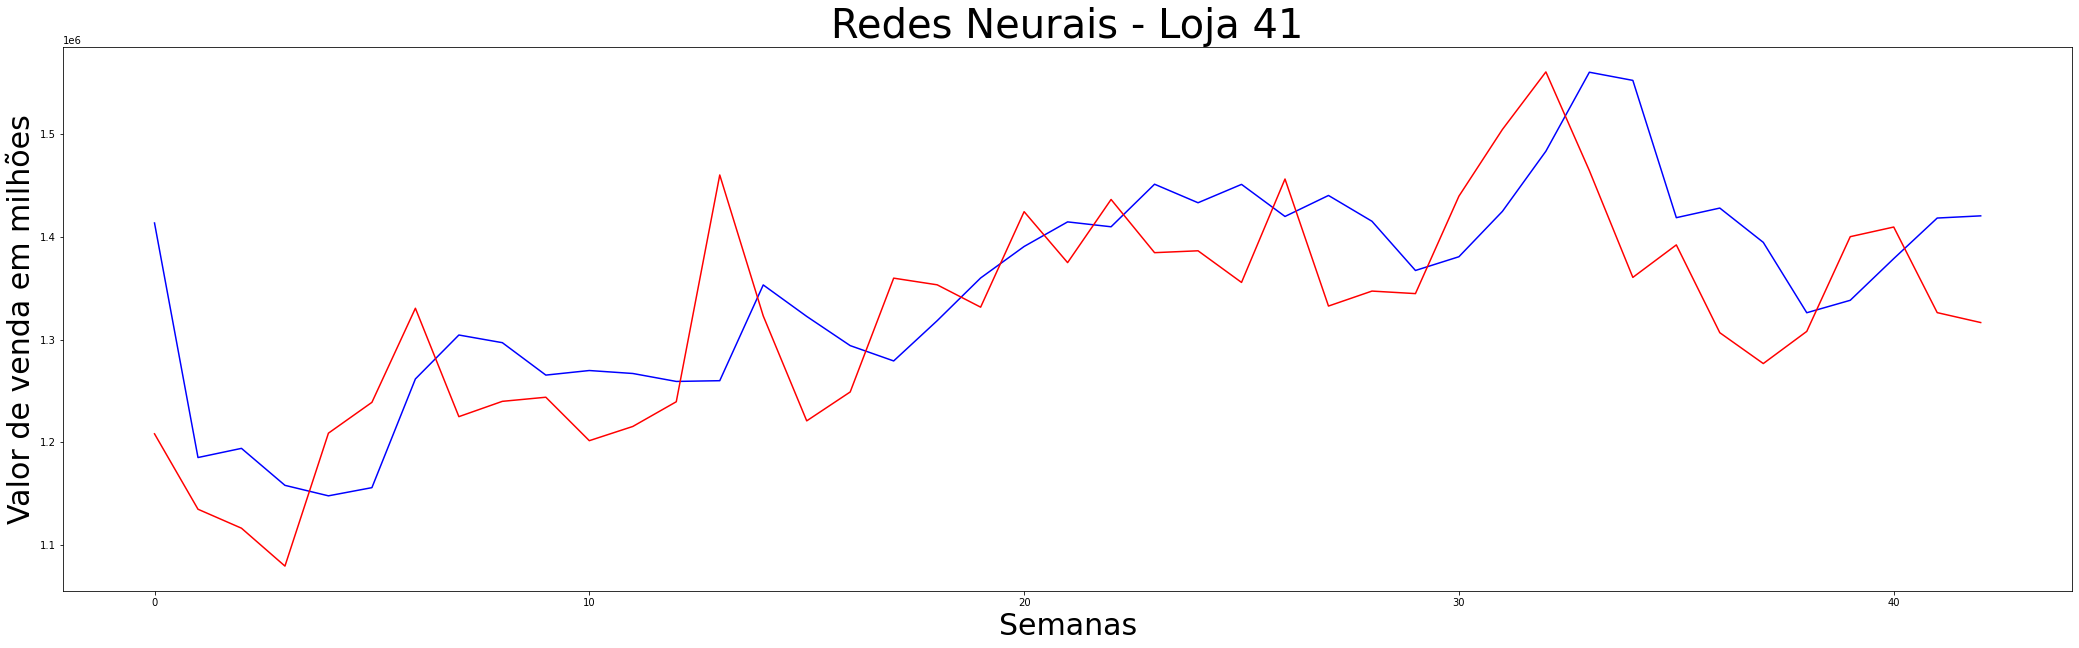

**************************************************
Resultados Loja 42:
-2.745494961333202 74910.69 93527.3


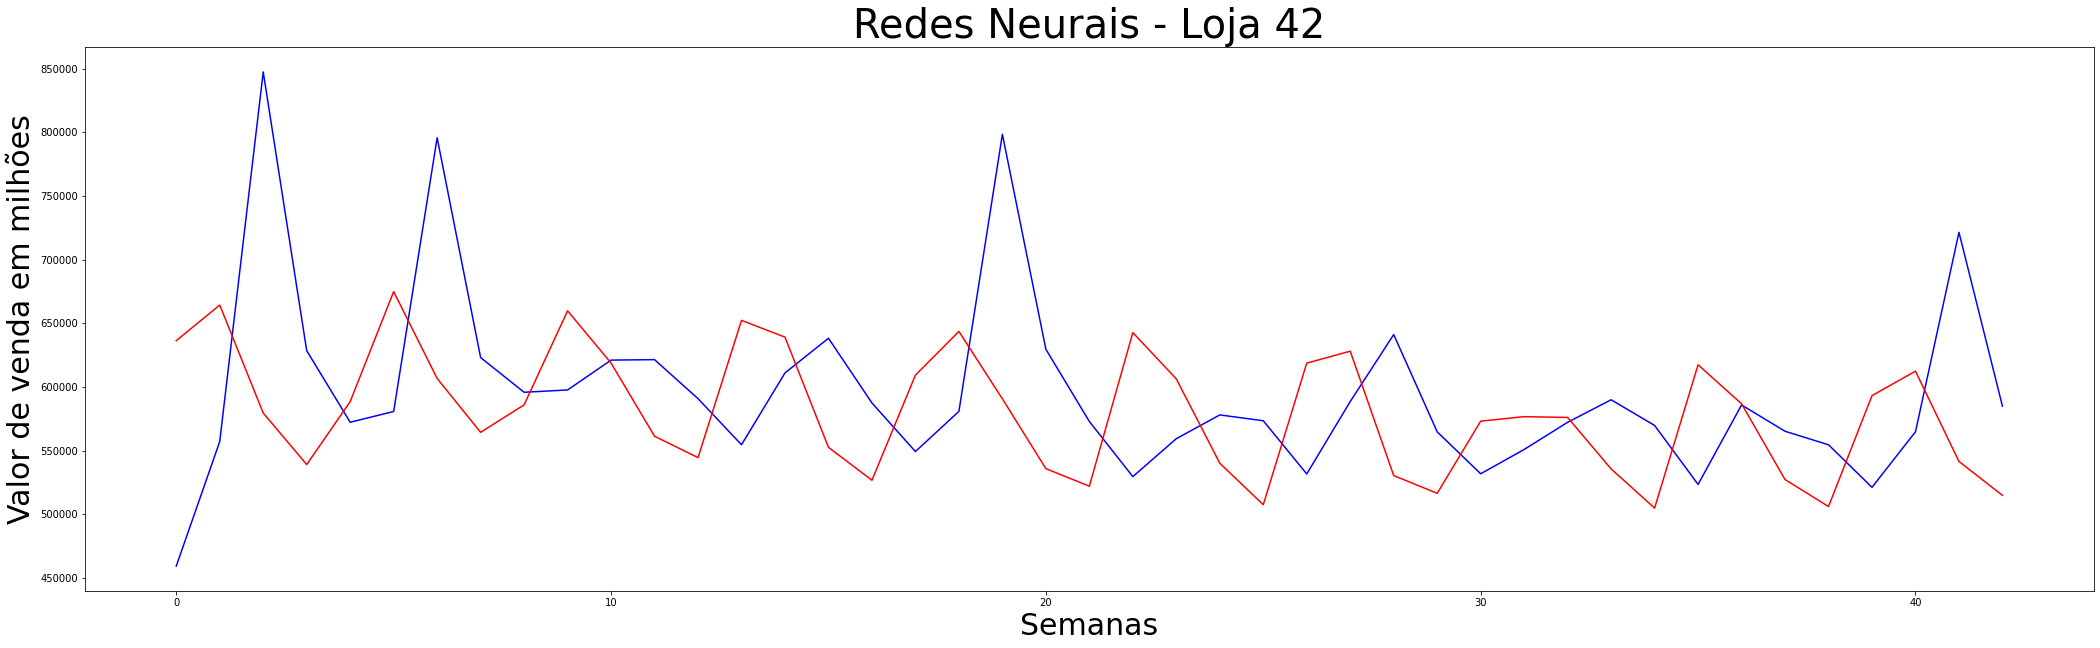

**************************************************
Resultados Loja 43:
-2.1168275902604283 37518.285 49662.63


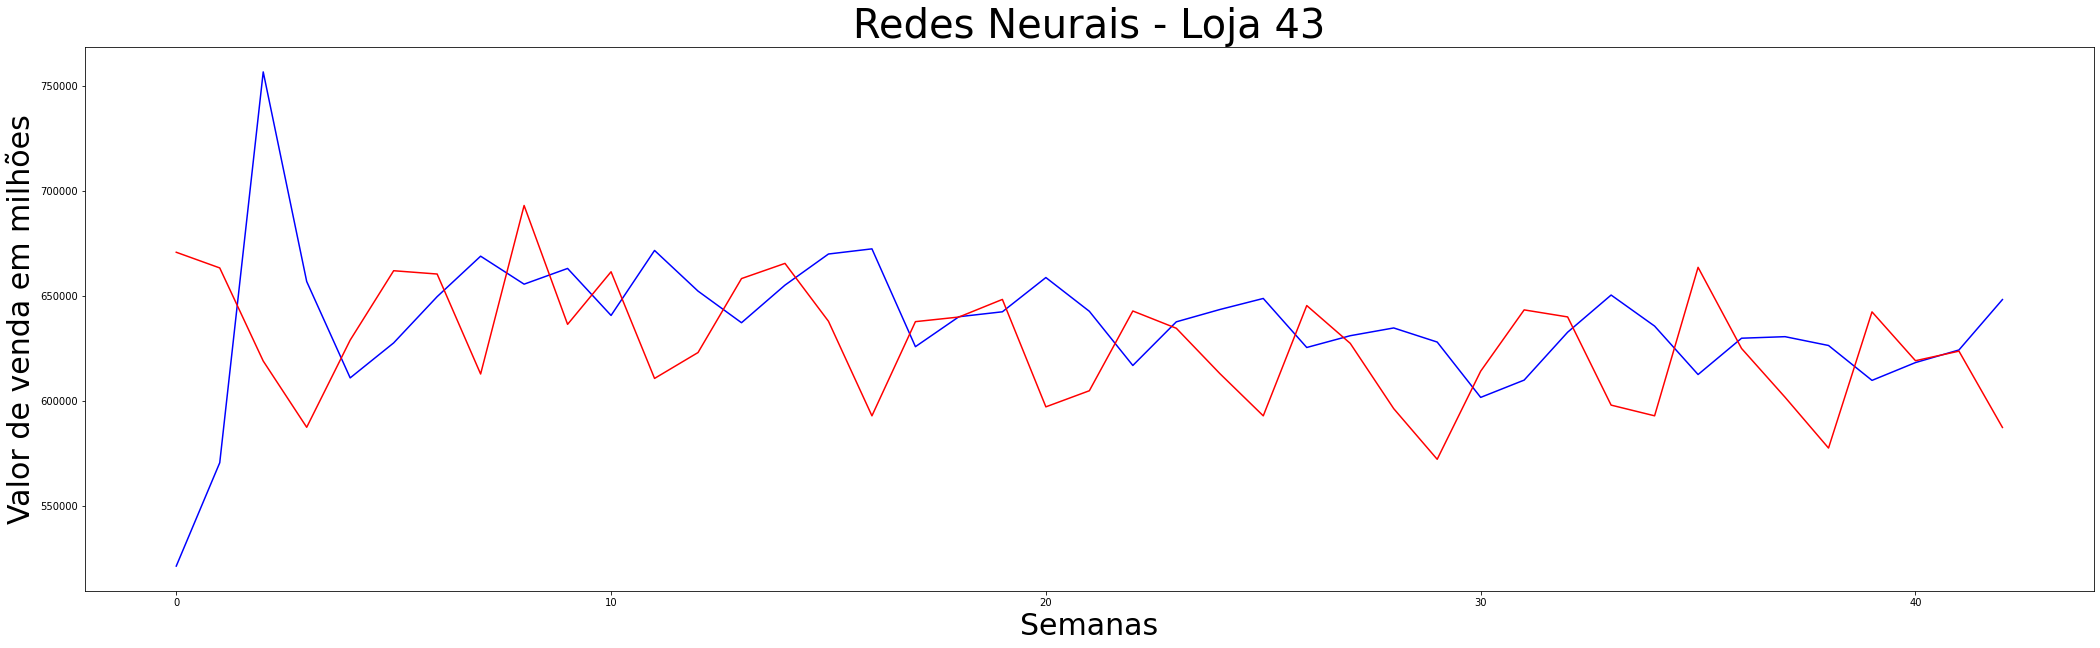

**************************************************
Resultados Loja 44:
0.024986790655468827 11196.069 13776.071


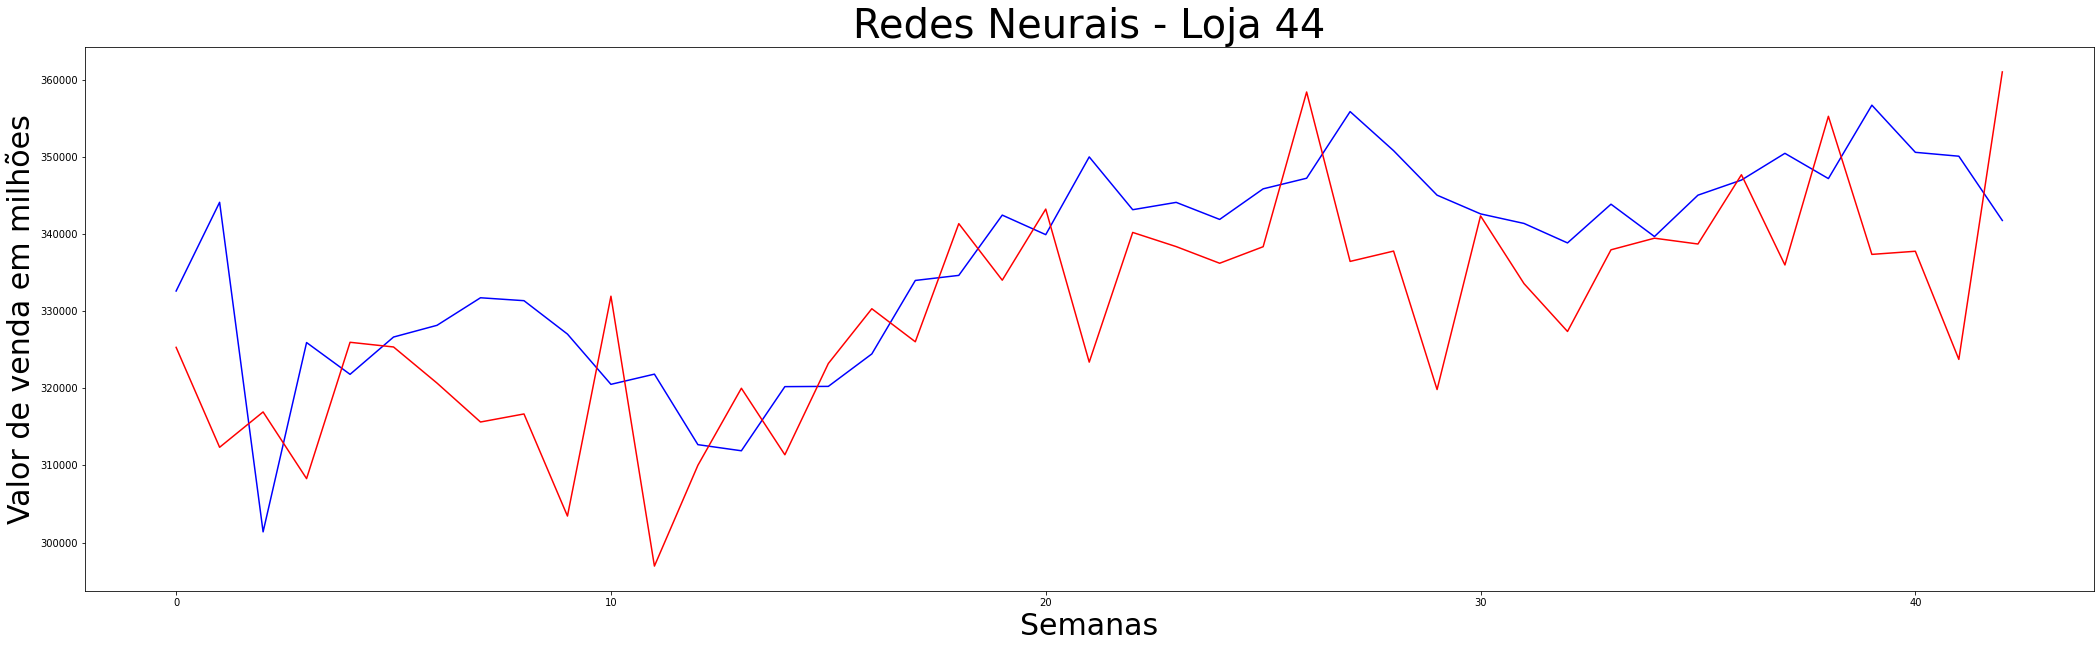

**************************************************
Resultados Loja 45:
-0.30412180557483826 42045.973 58948.668


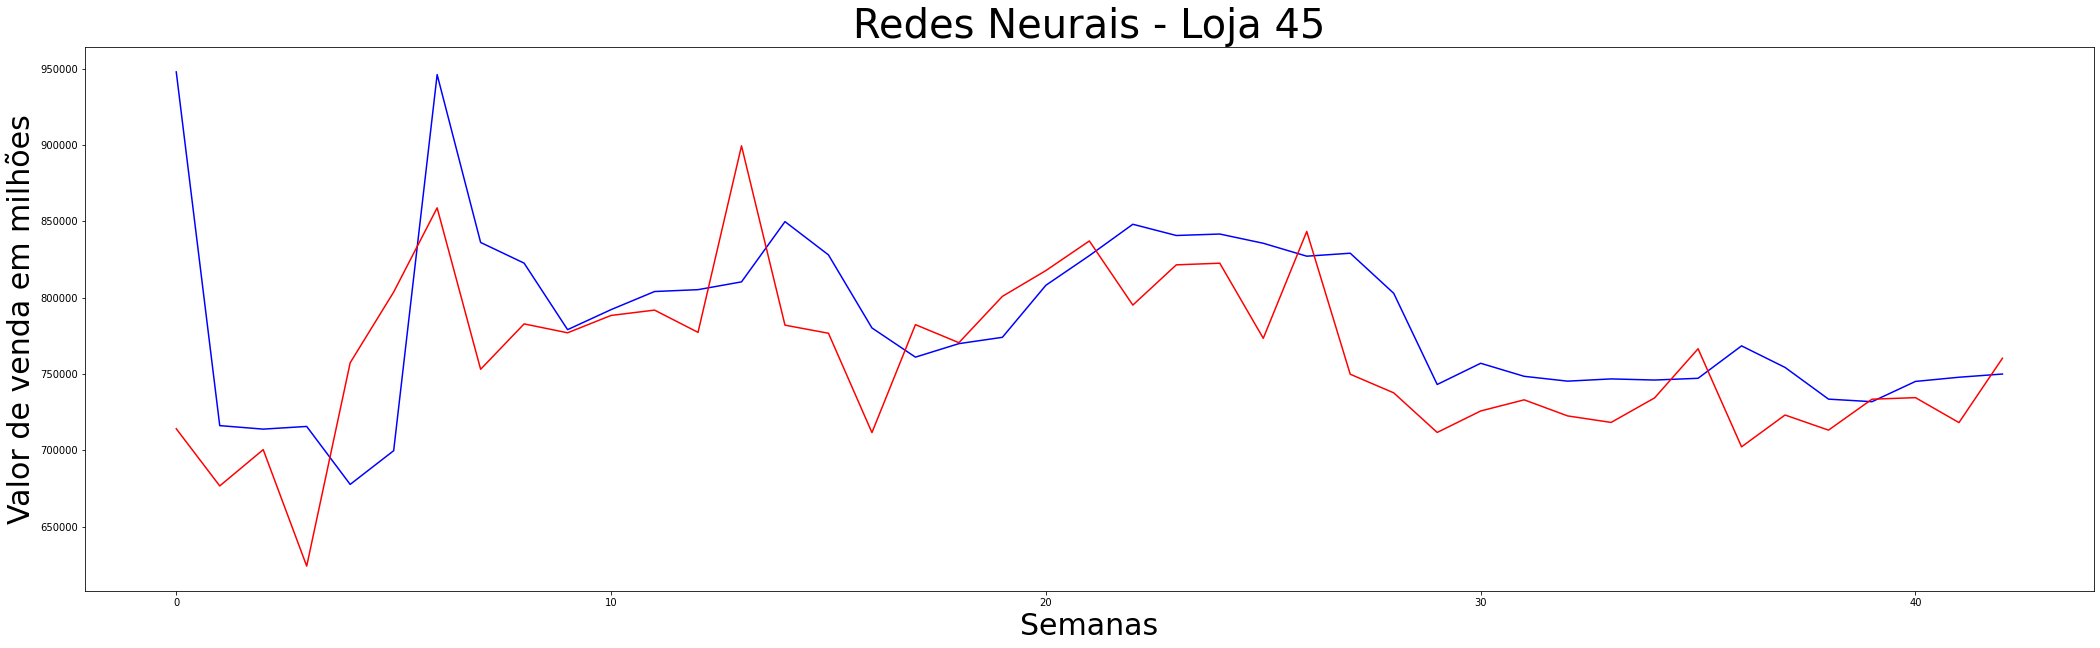

**************************************************


In [56]:
Xy_test = X_test
Xy_test["y"] = y_test

for i in range(1, 46):
  X_loja = Xy_test.where(Xy_test["Store_" + str(i)] == 1).dropna()
  y_loja = X_loja["y"]
  X_loja = X_loja.drop(["y"], axis=1)

  predictions_loja = model.predict(X_loja)

  print("Resultados Loja {}:".format(i))
  print(mean_absolute_error(y_loja, predictions_loja), np.sqrt(mean_squared_error(y_loja, predictions_loja)))
  
  plt.figure(figsize = (36, 10)) 
  plt.plot(range(len(predictions_loja)), predictions_loja, 'b')
  plt.plot(range(len(predictions_loja)), y_loja, 'r')
  plt.title("Redes Neurais - Loja {}".format(i), fontsize=40)
  plt.xlabel("Semanas", fontsize=30)
  plt.ylabel("Valor de venda em milhões", fontsize=30)

  plt.show()
  
  print(50*"*")
